# Importing Libraries

In [ ]:
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scp
import pandas as pd
import os
import random
import skimage as skio
import glob

# Importing Flowers102 dataset

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import os
from PIL import Image
import scipy.io as scp
import torch
import random

# Define transforms for both original and augmented datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augment_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the Flowers102 dataset
train_dataset = datasets.Flowers102(root="./", split='train', transform=transform, download=True)
test_dataset = datasets.Flowers102(root="./", split='test', transform=transform, download=True)


# Data paths for Flowers102
data_path = './flowers-102/jpg'
label_path = './flowers-102/imagelabels.mat'
setid_path = './flowers-102/setid.mat'

# Load label data and adjust to 0-based indexing
label_data = scp.loadmat(label_path)
label_array = label_data['labels']
label_array -= 1

# Load train indices and adjust to 0-based indexing
setid_data = scp.loadmat(setid_path)
train_indices = setid_data['trnid'][0] - 1

# Load training images and labels based on indices
image_files = sorted([f for f in os.listdir(data_path) if f.endswith('.jpg')])
train_images = [image_files[i] for i in train_indices]
train_labels = [label_array[0, i] for i in train_indices]



100%|██████████| 345M/345M [00:08<00:00, 38.7MB/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 828kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 14.1MB/s]


In [ ]:
# Loading the dataset

# Load the Flowers102 dataset (train split)
train_dataset = datasets.Flowers102(root = "./",split='train', transform=transform, download=True)
test_dataset = datasets.Flowers102(root = "./",split='test', transform=transform, download=True)

# Create a DataLoader to iterate through the dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [ ]:
# Defining transform function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

## Visualising the dataset

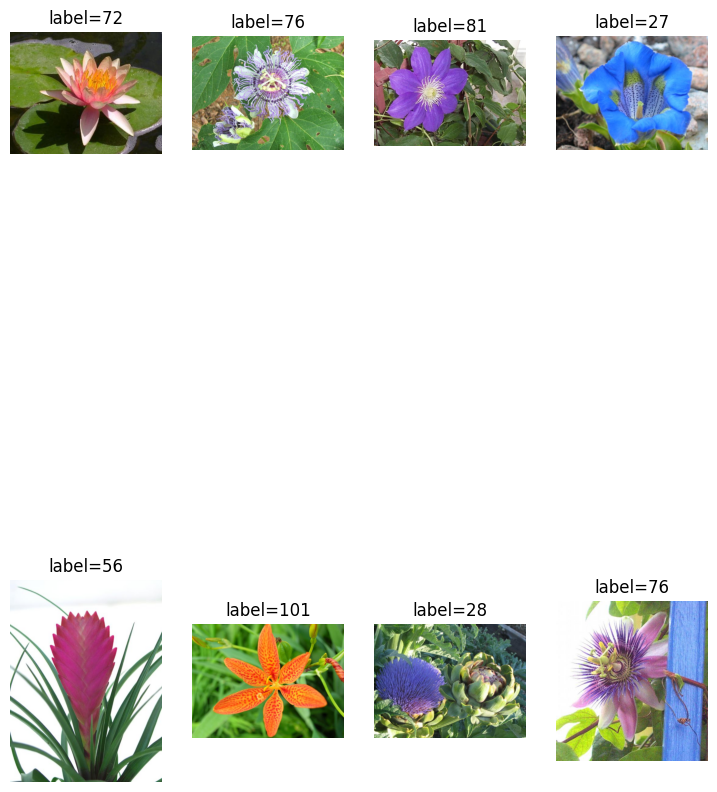

In [ ]:
from PIL import Image

data_path = './flowers-102/jpg'
label_path = './flowers-102/imagelabels.mat'
label_array = scp.loadmat(label_path)['labels']
label_array -= 1


# Now we're trying to visualise just random flowers at a time
fig, ax = plt.subplots(nrows= 2, ncols=4, figsize=(9,14))
image_num = random.sample(range(1,8190),8)
for i in range(2):
  for j in range(4):
    image =Image.open(os.path.join(data_path, f'image_{image_num[i*4+j]:05}.jpg'))
    ax[i,j].imshow(image)
    ax[i,j].axis('off')
    # Now to display labels
    ax[i,j].set_title(f'label={label_array[0, image_num[i*4+j]]}')


In [ ]:
sorted(os.listdir(data_path))[0]
os.path.join(data_path, sorted(os.listdir(data_path))[0])

'./flowers-102/jpg/image_00001.jpg'

In [ ]:
# Now converting our data into a dataframe
# Columns will be path to image file, and their label
label_list = list(label_array[0, :])
image_path_list = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
metadata = pd.DataFrame(
    {
        'image_path': image_path_list,
        'label': label_list
    }
)

In [ ]:
# viewing the dataframe
metadata

image_path  label
0     ./flowers-102/jpg/image_00001.jpg     76
1     ./flowers-102/jpg/image_00002.jpg     76
2     ./flowers-102/jpg/image_00003.jpg     76
3     ./flowers-102/jpg/image_00004.jpg     76
4     ./flowers-102/jpg/image_00005.jpg     76
...                                 ...    ...
8184  ./flowers-102/jpg/image_08185.jpg     61
8185  ./flowers-102/jpg/image_08186.jpg     61
8186  ./flowers-102/jpg/image_08187.jpg     61
8187  ./flowers-102/jpg/image_08188.jpg     61
8188  ./flowers-102/jpg/image_08189.jpg     61

[8189 rows x 2 columns]

# Augmented Dataset using Cutmix and Mixup algorithms

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, num_augmentations=5, mixup_alpha=0.4, cutmix_alpha=0.4):
        self.original_dataset = original_dataset
        self.num_augmentations = num_augmentations
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha

    def __len__(self):
        # Return the expanded length based on the number of augmentations per sample
        return len(self.original_dataset) * self.num_augmentations

    def __getitem__(self, idx):
        # Map the expanded index to the original dataset index
        original_idx = idx % len(self.original_dataset)
        img1, label1 = self.original_dataset[original_idx]

        # Apply either MixUp or CutMix randomly
        if random.random() < 0.5:
            img2, label2 = self._random_sample_except(original_idx)
            mixed_img, mixed_label_a, mixed_label_b, lam = self._mixup(img1, label1, img2, label2)
        else:
            img2, label2 = self._random_sample_except(original_idx)
            mixed_img, mixed_label_a, mixed_label_b, lam = self._cutmix(img1, label1, img2, label2)

        return mixed_img, mixed_label_a, mixed_label_b, lam

    def _random_sample_except(self, idx):
        """Randomly sample a different image and label."""
        rand_idx = random.choice([i for i in range(len(self.original_dataset)) if i != idx])
        return self.original_dataset[rand_idx]

    def _mixup(self, img1, label1, img2, label2):
        """Apply MixUp augmentation."""
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        mixed_img = lam * img1 + (1 - lam) * img2
        return mixed_img, label1, label2, lam

    def _cutmix(self, img1, label1, img2, label2):
        """Apply CutMix augmentation."""
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
        H, W = img1.shape[1:]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        # Randomly choose a position for the cutout region
        cx, cy = np.random.randint(W), np.random.randint(H)

        # Define the bounding box for CutMix
        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        # Apply CutMix augmentation
        mixed_img = img1.clone()
        mixed_img[:, bbx1:bbx2, bby1:bby2] = img2[:, bbx1:bbx2, bby1:bby2]

        # Adjust the labels proportionally
        lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))
        return mixed_img, label1, label2, lam_adjusted

# Original dataset
original_dataset = datasets.Flowers102(root="./", split='train', transform=transform, download=True)

# Create an augmented dataset
augmented_dataset = AugmentedDataset(original_dataset)

# DataLoader for the augmented dataset
train_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)



In [ ]:
len(train_loader.dataset)

5100

# Convolutional Neural Network


## Building the network

In [ ]:
class myCNN(nn.Module):
  def __init__(self, num_channels=3, num_out_ch = [8,16], img_w= 100, img_h = 100, num_classes = 102):
    super(myCNN, self).__init__()
    # defining different components for model
    # 2 initial convolutional layers, and then a fully connected layer, and the output of the fully connected layer is the output layer
    self.conv1 = nn.Conv2d(in_channels = num_channels, out_channels = num_out_ch[0],
                           #Need to define in channels, and output channels
                           kernel_size = [3,3], # 3 by 3 kernel
                           stride = [1,1], #Not going to jump any pixel
                           padding = [1,1] # Adding an outer layer of empty pixels to the image
                           )
    self.conv2 = nn.Conv2d(in_channels = num_out_ch[0], out_channels = num_out_ch[1], kernel_size = [3,3], stride = [1,1], padding = [1,1])
    # Utilising the maxpull concept - Decreases the dimensions of the image
    self.pool = nn.MaxPool2d(kernel_size=[2,2], stride = [2,2]) # Reduces the size of the image by half, then half again
    flattened_size = int(img_w/4) * int(img_h/4) * num_out_ch[1]
    self.fc1 = nn.Linear(in_features = flattened_size , out_features = num_classes)
  def forward(self, x):
    # # Continuously saving x into itself
    # x = F.relu(self.conv1(x))
    # # After convolution, pool
    # x = self.pool(x)
    # # Second layer
    # x = F.relu(self.conv2(x))
    # x = self.pool(x)
    # print(f"Shape before flattening: {x.shape}")
    # x = self.fc1(x.reshape(x.shape[0],-1))
    # print(f"Shape after flattening: {x.shape}")
    try:
        # print(f"Input shape: {x.shape}")  # Check the input shape

        # Pass through the first conv layer
        x = F.relu(self.conv1(x))
        # print(f"After conv1: {x.shape}")

        # After the first pooling layer
        x = self.pool(x)
        # print(f"After pool1: {x.shape}")

        # Pass through the second conv layer
        x = F.relu(self.conv2(x))
        # print(f"After conv2: {x.shape}")

        # After the second pooling layer
        x = self.pool(x)
        # print(f"After pool2: {x.shape}")

        # Flatten the tensor
        x = x.reshape(x.shape[0], -1)  # Flatten
        # print(f"After flattening: {x.shape}")

        # Pass through the Linear layer
        x = self.fc1(x)
        # print(f"After fc1: {x.shape}")

        return x

    except Exception as e:
        print(f"An error occurred: {e}")
        raise  # Re-raise the exception to see the full traceback
    return x

In [ ]:
# Testing model
model = myCNN()
x = torch.randn(32,3,100,100)
y = model(x)
print(y.shape) # Expectation: 2

torch.Size([32, 102])


## Hyperparameters, device, model, optimizer, loss function

In [ ]:
# Hyperparameters (Parameters are all capital letters by convention)
NUM_OUT_CH = [8,16] # as before
IMAGE_W, IMAGE_H = 200, 200
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Model
model = myCNN(num_channels = 3, num_out_ch = NUM_OUT_CH, img_w = IMAGE_W, img_h = IMAGE_H, num_classes = 102)
model.to(device)

# Optimiser
optimiser = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Loss function: Cross Entropy Loss for now
criterion = nn.CrossEntropyLoss()


cuda


## Loading data into dataset

In [ ]:
class Flower_Dataset(torch.utils.data.Dataset):
  def __init__(self, metadata, transform = None):
    self.metadata = metadata
    self.transform = transform
  def __len__(self):
    return len(self.metadata)
  def __getitem__(self, idx): # Inputs: a single index, outputs an image and a label
    path = self.metadata.iloc[idx, 0] # Access path from dataframe
    try:
      image  = Image.open(path).convert('RGB')
    except:
      print(f"Error loading image at path{path}")
      raise
    label = torch.tensor(int(self.metadata.iloc[idx,1])) # Convert into tensor
    # Issue: 1 number representing the class of flower
    # Our model predicts a vector of 102 values for EVERY single image
    # Ideal world: One single class has a '1' value, and the other classes have '0' value
    label = F.one_hot(label, num_classes = 102)
    label =label.float() # One hot encoded value needs to be able to be floated
    if self.transform:
      image = self.transform(image)
    return image, label

# What should be our transformation?
flower_transform = transforms.Compose([ # Allows us to stack multiple transforms on top of each other
    transforms.Resize((IMAGE_W, IMAGE_H)),
    # Transform into tensor
    transforms.ToTensor(),
    # Average RGB pixel value and standard deviation among all pixels in our dataset
    transforms.Normalize((0.4355, 0.3777, 0.2879),(0.2615, 0.2080, 0.2151))
])

dataset = Flower_Dataset(metadata, transform = flower_transform)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [6500, 1689])
# Batch sizes are already there as a hyperparameter
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
train_loader
for x, y in train_loader:
    print(f"Image batch shape: {x.shape}")  # Should be [batch_size, 3, H, W]
    print(f"Label batch shape: {y.shape}")  # Should be [batch_size, 102]
    break

Image batch shape: torch.Size([64, 3, 200, 200])
Label batch shape: torch.Size([64, 102])


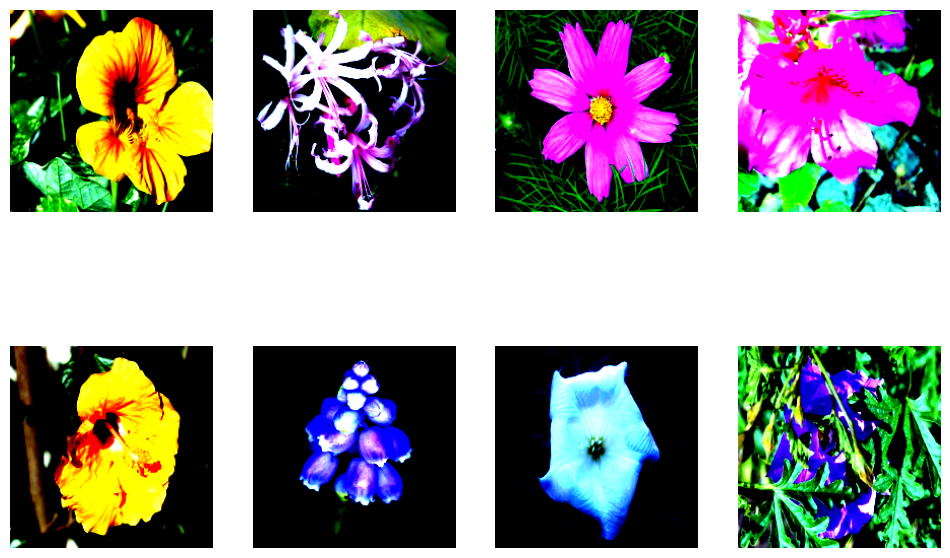

In [ ]:
# verifying data being loaded in the dataloaders

for x. y in train_loader:
  x = x.to(device)
  fig, axis = plt.subplots(nrows = 2, ncols = 4, figsize = (12,8))
  for i in range(2):
    for j in range(4):
      axis[i,j].imshow(x[i*4+j].cpu().permute(1,2,0))
      axis[i,j].axis('off')
  break

## CNN Training Loop

In [ ]:
# training loop
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
def accuracy(model, data_loader):
  model.eval()
  all_preds, all_labels = [],[]
  with torch.no_grad():
    for x,y in data_loader:
      x, y = x.to(device), y.to(device)
      y_pred = model(x)
      preds = torch.argmax(y_pred, dim = 1)
      labels = torch.argmax(y, dim = 1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
  # Two different metircs
  accuracy = accuracy_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds, average = 'weighted')
  print(f"Accuracy: {accuracy}, F1 Score: {f1}")

for epoch in range(NUM_EPOCHS):
  running_loss = 0
  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
  for index, (x,y) in enumerate(progress_bar):
    # send data to device
    x,y = x.to(device), y.to(device)
    # print("Sanity check")
    loss = criterion(model(x),y)
    running_loss += loss.item()
    # backpropogation
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  print(f"Epoch: {epoch+1}, Loss: {running_loss}")
  accuracy(model, test_loader)

Epoch 1/20: 100%|██████████| 102/102 [00:39<00:00,  2.59it/s]


Epoch: 1, Loss: 386.93480253219604
Accuracy: 0.29307282415630553, F1 Score: 0.2594270949735452


Epoch 2/20: 100%|██████████| 102/102 [00:40<00:00,  2.52it/s]


Epoch: 2, Loss: 131.16147857904434
Accuracy: 0.3475429248075784, F1 Score: 0.32667451095897715


Epoch 3/20: 100%|██████████| 102/102 [00:39<00:00,  2.59it/s]


Epoch: 3, Loss: 19.045234575867653
Accuracy: 0.35227945529899346, F1 Score: 0.3422998127587983


Epoch 4/20: 100%|██████████| 102/102 [00:39<00:00,  2.56it/s]


Epoch: 4, Loss: 2.8150188350118697
Accuracy: 0.3984606275902901, F1 Score: 0.3829822252766818


Epoch 5/20: 100%|██████████| 102/102 [00:41<00:00,  2.48it/s]


Epoch: 5, Loss: 0.8743732320144773
Accuracy: 0.3960923623445826, F1 Score: 0.3850151484804278


Epoch 6/20: 100%|██████████| 102/102 [00:40<00:00,  2.54it/s]


Epoch: 6, Loss: 0.2967761472100392
Accuracy: 0.40319715808170514, F1 Score: 0.38962311567092467


Epoch 7/20: 100%|██████████| 102/102 [00:40<00:00,  2.51it/s]


Epoch: 7, Loss: 0.17354816914303228
Accuracy: 0.4067495559502664, F1 Score: 0.3910574686169976


Epoch 8/20: 100%|██████████| 102/102 [00:40<00:00,  2.53it/s]


Epoch: 8, Loss: 0.12599178997334093
Accuracy: 0.4067495559502664, F1 Score: 0.3914795030230181


Epoch 9/20: 100%|██████████| 102/102 [00:41<00:00,  2.46it/s]


Epoch: 9, Loss: 0.09768008848186582
Accuracy: 0.4055654233274127, F1 Score: 0.39176099803434455


Epoch 10/20: 100%|██████████| 102/102 [00:40<00:00,  2.53it/s]


Epoch: 10, Loss: 0.07812522439053282
Accuracy: 0.40378922439313203, F1 Score: 0.39010463208220375


Epoch 11/20: 100%|██████████| 102/102 [00:40<00:00,  2.54it/s]


Epoch: 11, Loss: 0.06444293868844397
Accuracy: 0.4061574896388396, F1 Score: 0.39216357474957925


Epoch 12/20: 100%|██████████| 102/102 [00:41<00:00,  2.45it/s]


Epoch: 12, Loss: 0.05385242181364447
Accuracy: 0.4061574896388396, F1 Score: 0.39278990595775237


Epoch 13/20: 100%|██████████| 102/102 [00:40<00:00,  2.53it/s]


Epoch: 13, Loss: 0.04571697022765875
Accuracy: 0.40319715808170514, F1 Score: 0.38796665807331504


Epoch 14/20: 100%|██████████| 102/102 [00:40<00:00,  2.52it/s]


Epoch: 14, Loss: 0.039335746463621035
Accuracy: 0.4061574896388396, F1 Score: 0.39204816265439285


Epoch 15/20: 100%|██████████| 102/102 [00:40<00:00,  2.51it/s]


Epoch: 15, Loss: 0.03403743146918714
Accuracy: 0.4049733570159858, F1 Score: 0.3900358964047475


Epoch 16/20: 100%|██████████| 102/102 [00:40<00:00,  2.52it/s]


Epoch: 16, Loss: 0.02988996496424079
Accuracy: 0.4055654233274127, F1 Score: 0.3900392276956331


Epoch 17/20: 100%|██████████| 102/102 [00:40<00:00,  2.54it/s]


Epoch: 17, Loss: 0.026278756951796822
Accuracy: 0.4061574896388396, F1 Score: 0.39097492482274


Epoch 18/20: 100%|██████████| 102/102 [00:39<00:00,  2.56it/s]


Epoch: 18, Loss: 0.02328139711607946
Accuracy: 0.4067495559502664, F1 Score: 0.3914495335986275


Epoch 19/20: 100%|██████████| 102/102 [00:41<00:00,  2.49it/s]


Epoch: 19, Loss: 0.020681369067460764
Accuracy: 0.4061574896388396, F1 Score: 0.3909083774137427


Epoch 20/20: 100%|██████████| 102/102 [00:39<00:00,  2.55it/s]


Epoch: 20, Loss: 0.018572400833363645
Accuracy: 0.4049733570159858, F1 Score: 0.38966600690315273


# Simple Transformer Model

In [ ]:
import torch
from torchvision import datasets, transforms

# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resizing images for the transformer input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # Standard normalization
])

# Load training and validation datasets
train_data = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_data = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)

print(len(train_data))

100%|██████████| 345M/345M [00:14<00:00, 24.4MB/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1.43MB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 18.8MB/s]

1020


In [ ]:
print(train_data[0][0])
print(train_data[0][1])

tensor([[[-1.9467, -1.9295, -1.8439,  ...,  0.1426,  0.3481,  0.3309],
         [-1.8953, -1.8953, -1.8097,  ...,  0.1768,  0.3481,  0.3481],
         [-1.8268, -1.8439, -1.8268,  ...,  0.2282,  0.3481,  0.3481],
         ...,
         [-1.5870, -1.5870, -1.6384,  ..., -0.0458, -0.0458, -0.0801],
         [-1.6898, -1.6213, -1.6042,  ..., -0.0629, -0.0629, -0.0801],
         [-1.7069, -1.6898, -1.6042,  ..., -0.0458, -0.0801, -0.0972]],

        [[-1.6681, -1.6331, -1.5105,  ..., -0.3550, -0.2150, -0.3025],
         [-1.6506, -1.6155, -1.4930,  ..., -0.3375, -0.2325, -0.3025],
         [-1.6331, -1.6155, -1.5455,  ..., -0.3025, -0.2675, -0.3025],
         ...,
         [-1.0553, -1.0728, -1.1429,  ..., -0.2675, -0.2675, -0.3025],
         [-1.1253, -1.0553, -1.0728,  ..., -0.2500, -0.3025, -0.3725],
         [-1.1429, -1.1253, -1.0553,  ..., -0.2150, -0.3200, -0.4076]],

        [[-1.6650, -1.6824, -1.6476,  ...,  0.6008,  0.9319,  0.8099],
         [-1.6302, -1.6650, -1.6302,  ...,  0

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

In [ ]:
len(datasets.Flowers102(root='./data',split='test', download=True,transform=transform))

6149

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleTransformer(nn.Module):
    def __init__(self, num_classes=102, embed_dim=256, num_heads=8, num_layers=4):
        super(SimpleTransformer, self).__init__()
        self.embed_dim = embed_dim

        # Patch Embedding (we flatten each 224x224 image into a sequence of patches)
        self.patch_size = 16  # Size of each patch (16x16 pixels)
        num_patches = (224 // self.patch_size) ** 2
        self.patch_embed = nn.Linear(self.patch_size * self.patch_size * 3, embed_dim)

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification Head
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Reshape and project input into patches
        B, C, H, W = x.size()
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(B, -1, self.patch_size * self.patch_size * C)  # Flatten patches
        x = self.patch_embed(x)

        # Add positional encoding
        x += self.positional_encoding[:, :x.size(1), :]

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Average pooling and classification head
        x = x.mean(dim=1)
        return self.classifier(x)


In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Define loss and optimizer
model = SimpleTransformer(num_classes=102)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training and evaluation functions
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Training loop

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1/20, Train Loss: 4.7745, Train Acc: 0.0078, Val Loss: 4.6053, Val Acc: 0.0157
Epoch 2/20, Train Loss: 4.6037, Train Acc: 0.0206, Val Loss: 4.5570, Val Acc: 0.0216
Epoch 3/20, Train Loss: 4.5629, Train Acc: 0.0098, Val Loss: 4.5320, Val Acc: 0.0167
Epoch 4/20, Train Loss: 4.5389, Train Acc: 0.0137, Val Loss: 4.5299, Val Acc: 0.0265
Epoch 5/20, Train Loss: 4.5218, Train Acc: 0.0118, Val Loss: 4.5215, Val Acc: 0.0235
Epoch 6/20, Train Loss: 4.4587, Train Acc: 0.0284, Val Loss: 4.5160, Val Acc: 0.0225
Epoch 7/20, Train Loss: 4.4581, Train Acc: 0.0275, Val Loss: 4.5128, Val Acc: 0.0206
Epoch 8/20, Train Loss: 4.4525, Train Acc: 0.0235, Val Loss: 4.5115, Val Acc: 0.0216
Epoch 9/20, Train Loss: 4.4508, Train Acc: 0.0255, Val Loss: 4.5089, Val Acc: 0.0284
Epoch 10/20, Train Loss: 4.4453, Train Acc: 0.0235, Val Loss: 4.5019, Val Acc: 0.0294
Epoch 11/20, Train Loss: 4.4362, Train Acc: 0.0275, Val Loss: 4.5008, Val Acc: 0.0275
Epoch 12/20, Train Loss: 4.4361, Train Acc: 0.0314, Val Loss: 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pretrained ViT Model

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load a pretrained Vision Transformer model
model = models.vit_b_16(weights='IMAGENET1K_V1')
model.heads.head = nn.Linear(model.heads.head.in_features, 102)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 199MB/s]


In [ ]:
import os
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Define paths to save model weights in Google Drive
best_model_path = '/content/drive/MyDrive/flower_classification_best.pth'
last_model_path = '/content/drive/MyDrive/flower_classification_last.pth'

# Training and evaluation functions
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

# Training loop with model saving
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 20
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved Best Model with Val Acc: {best_val_acc:.4f}')

# Save the final model weights
torch.save(model.state_dict(), last_model_path)
print("Saved Last Model")


Epoch 1/20, Train Loss: 4.5694, Train Acc: 0.0216, Val Loss: 4.1152, Val Acc: 0.0559
Saved Best Model with Val Acc: 0.0559
Epoch 2/20, Train Loss: 3.8064, Train Acc: 0.0824, Val Loss: 3.4172, Val Acc: 0.1794
Saved Best Model with Val Acc: 0.1794
Epoch 3/20, Train Loss: 3.0376, Train Acc: 0.2314, Val Loss: 2.8880, Val Acc: 0.2843
Saved Best Model with Val Acc: 0.2843
Epoch 4/20, Train Loss: 2.4593, Train Acc: 0.3755, Val Loss: 2.6129, Val Acc: 0.3520
Saved Best Model with Val Acc: 0.3520
Epoch 5/20, Train Loss: 1.6711, Train Acc: 0.5980, Val Loss: 2.3067, Val Acc: 0.4186
Saved Best Model with Val Acc: 0.4186
Epoch 6/20, Train Loss: 0.8898, Train Acc: 0.8363, Val Loss: 1.9949, Val Acc: 0.5216
Saved Best Model with Val Acc: 0.5216
Epoch 7/20, Train Loss: 0.6199, Train Acc: 0.9343, Val Loss: 1.9446, Val Acc: 0.5343
Saved Best Model with Val Acc: 0.5343
Epoch 8/20, Train Loss: 0.4896, Train Acc: 0.9559, Val Loss: 1.9039, Val Acc: 0.5382
Saved Best Model with Val Acc: 0.5382
Epoch 9/20, Trai

# CNN, Transformer Hybrid Model

In [ ]:
##CNN Transformer Hybrid model
import torch
import torch.nn as nn
from torchvision.models import resnet50
class CNN_Transformer(nn.Module):
  def __init__(self, num_classes = 102, embed_dim = 256, num_heads = 8, num_layers = 6):
    super(CNN_Transformer, self).__init__()
    self.cnn = resnet50(pretrained=True)
    self.cnn = nn.Sequential(*list(self.cnn.children())[:-2])

    self.flatten = nn.Flatten(2)
    self.path_embedding = nn.Linear(2048, embed_dim)
    self.positional_encoding = nn.Parameter(torch.randn(1, 49, embed_dim))
    encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    self.classification_head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    features = self.cnn(x)
    batch_size, depth, height, width = features.size()
    features = features.view(batch_size, depth, height * width).permute(0, 2, 1)
    features = self.path_embedding(features)
    features += self.positional_encoding[:, :features.size(1), :]
    features = self.transformer_encoder(features)
    cls_features = features.mean(dim=1)
    output = self.classification_head(cls_features)
    return output

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.cuda.amp as amp  # For mixed precision training

cnntransmodel = CNN_Transformer(num_classes=102)  # Make sure num_classes matches your dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnntransmodel.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(cnntransmodel.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Slower learning rate decay

scaler = amp.GradScaler()  # Mixed precision training

def train(model, dataloader, loss_fn, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixed precision training
        with amp.autocast():
            outputs = model(images)
            loss = loss_fn(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def evaluate(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

for epoch in range(20):
    train_loss, train_acc = train(cnntransmodel, train_loader, loss_fn, optimizer, scaler)
    val_loss, val_acc = evaluate(cnntransmodel, val_loader, loss_fn)
    scheduler.step()

    print(f'Epoch {epoch+1}/{100}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

<ipython-input-11-1bd3ae986c6d>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  # Mixed precision training
<ipython-input-11-1bd3ae986c6d>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 1/100, Train Loss: 4.8352, Train Acc: 0.0029, Val Loss: 4.6666, Val Acc: 0.0098
Epoch 2/100, Train Loss: 4.7148, Train Acc: 0.0059, Val Loss: 4.6381, Val Acc: 0.0098
Epoch 3/100, Train Loss: 4.6952, Train Acc: 0.0029, Val Loss: 4.6335, Val Acc: 0.0098
Epoch 4/100, Train Loss: 4.6967, Train Acc: 0.0039, Val Loss: 4.6343, Val Acc: 0.0098
Epoch 5/100, Train Loss: 4.6866, Train Acc: 0.0029, Val Loss: 4.6313, Val Acc: 0.0098
Epoch 6/100, Train Loss: 4.6815, Train Acc: 0.0049, Val Loss: 4.6278, Val Acc: 0.0098
Epoch 7/100, Train Loss: 4.6762, Train Acc: 0.0059, Val Loss: 4.6241, Val Acc: 0.0098
Epoch 8/100, Train Loss: 4.6722, Train Acc: 0.0078, Val Loss: 4.6295, Val Acc: 0.0098
Epoch 9/100, Train Loss: 4.6289, Train Acc: 0.0098, Val Loss: 4.6254, Val Acc: 0.0118
Epoch 10/100, Train Loss: 4.4800, Train Acc: 0.0186, Val Loss: 4.3203, Val Acc: 0.0294
Epoch 11/100, Train Loss: 4.2213, Train Acc: 0.0235, Val Loss: 4.1758, Val Acc: 0.0343
Epoch 12/100, Train Loss: 4.1213, Train Acc: 0.0255,

# Multi-Loss Attention Network

## Training with Original Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import timm

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc1(self.global_avg_pool(x))
        out = self.fc2(F.relu(avg_out))
        return x * self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(out)
        return x * self.sigmoid(out)

# Multi-Attention Network with Xception Backbone
class MultiAttentionNetwork(nn.Module):
    def __init__(self, num_classes=102):
        super(MultiAttentionNetwork, self).__init__()
        # Load pretrained Xception from timm with input channels set to 3
        self.backbone = timm.create_model('xception', pretrained=True, in_chans=3)

        # Replace the final classifier layer with the correct in_features
        self.backbone.fc = nn.Linear(1024, num_classes)

        self.att1 = ChannelAttention(728)
        self.att2 = SpatialAttention()

    def forward(self, x):
        # Pass through initial layers of Xception
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.act1(x)
        x = self.backbone.conv2(x)
        x = self.backbone.bn2(x)
        x = self.backbone.act2(x)
        x = self.backbone.block1(x)
        x = self.backbone.block2(x)

        # Apply first Channel Attention after block3
        x = self.backbone.block3(x)
        x = self.att1(x)

        # Continue through blocks 4 to 11, and apply Spatial Attention after block11
        x = self.backbone.block4(x)
        x = self.backbone.block5(x)
        x = self.backbone.block6(x)
        x = self.backbone.block7(x)
        x = self.backbone.block8(x)
        x = self.backbone.block9(x)
        x = self.backbone.block10(x)
        x = self.backbone.block11(x)
        x = self.att2(x)

        # Finish with remaining blocks and global pool
        x = self.backbone.block12(x)
        x = self.backbone.global_pool(x)

        # Flatten the output from global pooling to match the input shape for the fully connected layer
        x = x.view(x.size(0), -1)
        return self.backbone.fc(x)



num_classes = 102
model = MultiAttentionNetwork(num_classes=num_classes)

print(model)


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


MultiAttentionNetwork(
  (backbone): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2):

In [ ]:

# Define MultiLoss class
class MultiLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(MultiLoss, self).__init__()
        self.softmax_loss = nn.CrossEntropyLoss()
        self.triplet_loss = nn.TripletMarginLoss(margin=margin)

    def forward(self, logits, labels, anchor, positive, negative):
        # Softmax loss for classification
        softmax_loss = self.softmax_loss(logits, labels)
        # Triplet loss for feature embeddings
        triplet_loss = self.triplet_loss(anchor, positive, negative)
        return softmax_loss + triplet_loss

# Instantiate criterion with MultiLoss
criterion = MultiLoss(margin=1.0)


In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transform for consistent resizing and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the Flowers102 dataset (train and test split)
train_dataset = datasets.Flowers102(root= "./", split='train', transform=transform, download=True)
test_dataset = datasets.Flowers102(root= "./", split='test', transform=transform, download=True)

# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")



Train dataset size: 1020
Test dataset size: 6149


In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

# Define the model with an explicit in_chans parameter
model = timm.create_model('xception', pretrained=True, in_chans=3)
model.fc = nn.Linear(model.get_classifier().in_features, 102)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model structure to verify the first convolution layer
print(model)

# Instantiate the model and move it to the device
num_classes = 102
model = MultiAttentionNetwork(num_classes=num_classes)
model.to(device)


# Instantiate model, loss, and optimizer
num_classes = 102
model = MultiAttentionNetwork(num_classes=num_classes)
model.to(device)

# Define optimizer and scheduler
optimizer = Adam(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training function
augmented_dataset = AugmentedDataset(original_dataset, num_augmentations=5)
train_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)

# Re-define the criterion to handle MixUp/CutMix augmented labels
class MixedLoss(nn.Module):
    def __init__(self):
        super(MixedLoss, self).__init__()
        self.softmax_loss = nn.CrossEntropyLoss()

    def forward(self, logits, label_a, label_b, lam):
        # MixUp or CutMix loss that combines labels with lam weight
        return lam * self.softmax_loss(logits, label_a) + (1 - lam) * self.softmax_loss(logits, label_b)

# Instantiate the new criterion for augmented labels
criterion = MixedLoss()

# Training function for augmented data with MixUp/CutMix
def train_epoch_augmented(model, train_loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for images, label_a, label_b, lam in train_loader:
        images, label_a, label_b = images.to(device), label_a.to(device), label_b.to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(images)

        # Compute loss with mixed labels
        loss = criterion(logits, label_a, label_b, lam)
        loss.backward()
        optimizer.step()

        # Update metrics
        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += (predicted == label_a).sum().item() * lam + (predicted == label_b).sum().item() * (1 - lam)

    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

# Evaluation function remains the same
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(test_loader.dataset), correct / len(test_loader.dataset)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [ ]:
# Main training loop with modified train_epoch_augmented
num_epochs = 20
best_val_acc = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_augmented(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, nn.CrossEntropyLoss())
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_flower_model.pth')
        print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")

# Test evaluation
test_loss, test_accuracy = evaluate_test(model, test_loader, nn.CrossEntropyLoss())
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [ ]:
import torch
import torch.nn as nn

# Load the best model weights
model.load_state_dict(torch.load('/content/drive/MyDrive/best_flower_model.pth', weights_only=True))
model.to(device)

# Define a standard loss function for evaluation (like CrossEntropy)
evaluation_criterion = nn.CrossEntropyLoss()

# Define the test evaluation function
def evaluate_test(model, test_loader, criterion):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            outputs = model(inputs)

            # Ensure outputs are in float32 for compatibility with criterion
            if outputs.dtype != torch.float32:
                outputs = outputs.float()

            # Compute loss using the simpler criterion
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    return test_loss, test_accuracy

# Run the evaluation on the test dataset
test_loss, test_accuracy = evaluate_test(model, test_loader, evaluation_criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 1.2242, Test Accuracy: 0.7442


## Training with Augmented Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import timm
import random
import numpy as np

# Channel Attention Module with Dropout
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16, dropout_prob=0.3):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc1(self.global_avg_pool(x))
        avg_out = self.dropout(F.relu(avg_out))
        out = self.fc2(avg_out)
        return x * self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(out)
        return x * self.sigmoid(out)

# Multi-Attention Network with Xception Backbone
class MultiAttentionNetwork(nn.Module):
    def __init__(self, num_classes=102):
        super(MultiAttentionNetwork, self).__init__()
        # Load pretrained Xception from timm with input channels set to 3
        self.backbone = timm.create_model('xception', pretrained=True, in_chans=3)

        # Attention Modules
        self.att1 = ChannelAttention(728)
        self.att2 = SpatialAttention()

        # Replace the classifier layer with a new fully connected layer for 102 classes
        self.backbone.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Initial convolution and pooling layers
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.act1(x)
        x = self.backbone.conv2(x)
        x = self.backbone.bn2(x)
        x = self.backbone.act2(x)
        x = self.backbone.block1(x)
        x = self.backbone.block2(x)

        # Apply channel attention after block3 (728 channels)
        x = self.backbone.block3(x)
        x = self.att1(x)

        # Pass through remaining layers in the backbone
        x = self.backbone.block4(x)
        x = self.backbone.block5(x)
        x = self.backbone.block6(x)
        x = self.backbone.block7(x)
        x = self.backbone.block8(x)
        x = self.backbone.block9(x)
        x = self.backbone.block10(x)
        x = self.backbone.block11(x)

        # Apply spatial attention after block11 (1024 channels)
        x = self.att2(x)

        # Final layers
        x = self.backbone.block12(x)
        x = self.backbone.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to match fc input

        return self.backbone.fc(x)

# Mixed Loss to handle augmented labels
class MixedLoss(nn.Module):
    def __init__(self):
        super(MixedLoss, self).__init__()
        self.softmax_loss = nn.CrossEntropyLoss()

    def forward(self, logits, label_a, label_b, lam):
        # Move lam to the device of logits
        lam = lam.to(logits.device)
        return (lam * self.softmax_loss(logits, label_a) + (1 - lam) * self.softmax_loss(logits, label_b)).mean()


# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_val_loss is None or val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Model, criterion, optimizer, and scheduler setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiAttentionNetwork(num_classes=102).to(device)
criterion = MixedLoss()
optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)  # L2 regularization
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
early_stopping = EarlyStopping(patience=7)

# Training function for augmented data with MixUp/CutMix
def train_epoch_augmented(model, train_loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for images, label_a, label_b, lam in train_loader:
        # Move all inputs and labels to the same device
        images = images.to(device)
        label_a = label_a.to(device)
        label_b = label_b.to(device)

        # Ensure `lam` is on the correct device
        lam = lam.to(device) if torch.is_tensor(lam) else torch.tensor([lam], device=device)

        # If `lam` is a scalar, expand it across the batch dimension
        if lam.dim() == 0:
            lam = lam.expand(images.size(0)).to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(images)

        # Compute loss with mixed labels
        loss = criterion(logits, label_a, label_b, lam)
        loss.backward()
        optimizer.step()

        # Calculate predictions
        _, predicted = logits.max(1)

        # Ensure all elements are sized correctly for accuracy calculation
        min_size = min(predicted.size(0), label_a.size(0), label_b.size(0), lam.size(0))
        predicted = predicted[:min_size]
        label_a = label_a[:min_size]
        label_b = label_b[:min_size]
        lam = lam[:min_size]

        # Update metrics with element-wise multiplication for lam
        total_loss += loss.item() * images.size(0)
        correct += (predicted.eq(label_a) * lam + predicted.eq(label_b) * (1 - lam)).sum().item()

    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(test_loader.dataset), correct / len(test_loader.dataset)

# Training Loop with Early Stopping
num_epochs = 20
best_val_acc = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_augmented(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, nn.CrossEntropyLoss())
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_flower_model.pth')
        print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Test evaluation
test_loss, test_accuracy = evaluate(model, test_loader, nn.CrossEntropyLoss())
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/20, Train Loss: 3.4945, Train Acc: 0.5253, Val Loss: 1.8339, Val Acc: 0.7372
Best model saved with validation accuracy: 0.7372
Epoch 2/20, Train Loss: 2.7565, Train Acc: 0.7481, Val Loss: 2.0565, Val Acc: 0.7509
Best model saved with validation accuracy: 0.7509
Epoch 3/20, Train Loss: 2.6145, Train Acc: 0.7627, Val Loss: 1.7549, Val Acc: 0.8154
Best model saved with validation accuracy: 0.8154
Epoch 4/20, Train Loss: 2.4991, Train Acc: 0.7605, Val Loss: 1.7041, Val Acc: 0.8192
Best model saved with validation accuracy: 0.8192
Epoch 5/20, Train Loss: 2.4233, Train Acc: 0.7616, Val Loss: 1.8885, Val Acc: 0.7964
Epoch 6/20, Train Loss: 2.3188, Train Acc: 0.7594, Val Loss: 1.9363, Val Acc: 0.8336
Best model saved with validation accuracy: 0.8336
Epoch 7/20, Train Loss: 2.2782, Train Acc: 0.7594, Val Loss: 1.8525, Val Acc: 0.8458
Best model saved with validation accuracy: 0.8458
Epoch 8/20, Train Loss: 2.2514, Train Acc: 0.7650, Val Loss: 1.8829, Val Acc: 0.8468
Best model saved wit

## Experimenting with dual attention layers:
Dual Attention Layers: Place a second set of ChannelAttention and SpatialAttention modules after an intermediate block (e.g., block8). This second set of attention layers will help the model capture nuances at multiple levels of the feature hierarchy.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import timm
import random
import numpy as np

# Channel Attention Module with Dropout
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16, dropout_prob=0.3):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc1(self.global_avg_pool(x))
        avg_out = self.dropout(F.relu(avg_out))
        out = self.fc2(avg_out)
        return x * self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(out)
        return x * self.sigmoid(out)

# Multi-Attention Network with Dual Attention for Finer Details
class MultiAttentionNetwork(nn.Module):
    def __init__(self, num_classes=102):
        super(MultiAttentionNetwork, self).__init__()
        # Load pretrained Xception from timm with input channels set to 3
        self.backbone = timm.create_model('xception', pretrained=True, in_chans=3)

        # Attention Modules
        self.att1 = ChannelAttention(728)
        self.att2 = SpatialAttention()
        self.att3 = ChannelAttention(728)
        self.att4 = SpatialAttention()

        self.backbone.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Initial layers
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.act1(x)
        x = self.backbone.conv2(x)
        x = self.backbone.bn2(x)
        x = self.backbone.act2(x)
        x = self.backbone.block1(x)
        x = self.backbone.block2(x)

        x = self.backbone.block3(x)
        x = self.att1(x)
        x = self.att2(x)

        # Intermediate blocks
        x = self.backbone.block4(x)
        x = self.backbone.block5(x)
        x = self.backbone.block6(x)
        x = self.backbone.block7(x)

        x = self.backbone.block8(x)
        x = self.att3(x)
        x = self.att4(x)

        x = self.backbone.block9(x)
        x = self.backbone.block10(x)
        x = self.backbone.block11(x)
        x = self.backbone.block12(x)
        x = self.backbone.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to match fc input

        return self.backbone.fc(x)

# Mixed Loss to handle augmented labels
class MixedLoss(nn.Module):
    def __init__(self):
        super(MixedLoss, self).__init__()
        self.softmax_loss = nn.CrossEntropyLoss()

    def forward(self, logits, label_a, label_b, lam):
        # Move lam to the device of logits
        lam = lam.to(logits.device)
        return (lam * self.softmax_loss(logits, label_a) + (1 - lam) * self.softmax_loss(logits, label_b)).mean()


# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_val_loss is None or val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Model, criterion, optimizer, and scheduler setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiAttentionNetwork(num_classes=102).to(device)
criterion = MixedLoss()
optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)  # L2 regularization
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
early_stopping = EarlyStopping(patience=7)

# Training function for augmented data with MixUp/CutMix
def train_epoch_augmented(model, train_loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for images, label_a, label_b, lam in train_loader:
        # Move all inputs and labels to the same device
        images = images.to(device)
        label_a = label_a.to(device)
        label_b = label_b.to(device)

        # Ensure `lam` is on the correct device
        lam = lam.to(device) if torch.is_tensor(lam) else torch.tensor([lam], device=device)

        # If `lam` is a scalar, expand it across the batch dimension
        if lam.dim() == 0:
            lam = lam.expand(images.size(0)).to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(images)

        # Compute loss with mixed labels
        loss = criterion(logits, label_a, label_b, lam)
        loss.backward()
        optimizer.step()

        # Calculate predictions
        _, predicted = logits.max(1)

        # Ensure all elements are sized correctly for accuracy calculation
        min_size = min(predicted.size(0), label_a.size(0), label_b.size(0), lam.size(0))
        predicted = predicted[:min_size]
        label_a = label_a[:min_size]
        label_b = label_b[:min_size]
        lam = lam[:min_size]

        # Update metrics with element-wise multiplication for lam
        total_loss += loss.item() * images.size(0)
        correct += (predicted.eq(label_a) * lam + predicted.eq(label_b) * (1 - lam)).sum().item()

    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(test_loader.dataset), correct / len(test_loader.dataset)

# Training Loop with Early Stopping
num_epochs = 20
best_val_acc = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_augmented(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, nn.CrossEntropyLoss())
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_flower_model.pth')
        print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Test evaluation
test_loss, test_accuracy = evaluate(model, test_loader, nn.CrossEntropyLoss())
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Epoch 1/20, Train Loss: 4.4274, Train Acc: 0.0854, Val Loss: 3.3406, Val Acc: 0.2667
Best model saved with validation accuracy: 0.2667
Epoch 2/20, Train Loss: 3.6082, Train Acc: 0.4528, Val Loss: 1.9820, Val Acc: 0.6490
Best model saved with validation accuracy: 0.6490
Epoch 3/20, Train Loss: 3.1642, Train Acc: 0.6643, Val Loss: 1.6996, Val Acc: 0.7505
Best model saved with validation accuracy: 0.7505
Epoch 4/20, Train Loss: 3.0237, Train Acc: 0.7112, Val Loss: 1.7315, Val Acc: 0.7805
Best model saved with validation accuracy: 0.7805
Epoch 5/20, Train Loss: 2.8533, Train Acc: 0.7351, Val Loss: 1.7160, Val Acc: 0.8022
Best model saved with validation accuracy: 0.8022
Epoch 6/20, Train Loss: 2.7699, Train Acc: 0.7465, Val Loss: 1.7205, Val Acc: 0.8229
Best model saved with validation accuracy: 0.8229
Epoch 7/20, Train Loss: 2.7011, Train Acc: 0.7620, Val Loss: 1.6691, Val Acc: 0.8419
Best model saved with validation accuracy: 0.8419
Epoch 8/20, Train Loss: 2.6371, Train Acc: 0.7622, Val 

## Training again to generate graphs

Epoch 1/20, Train Loss: 3.9548, Train Acc: 0.3161, Val Loss: 2.1719, Val Acc: 0.6538
Best model saved with validation accuracy: 0.6538
Epoch 2/20, Train Loss: 3.0617, Train Acc: 0.6753, Val Loss: 1.7301, Val Acc: 0.7883
Best model saved with validation accuracy: 0.7883
Epoch 3/20, Train Loss: 2.8026, Train Acc: 0.7378, Val Loss: 1.8512, Val Acc: 0.8068
Best model saved with validation accuracy: 0.8068
Epoch 4/20, Train Loss: 2.6986, Train Acc: 0.7435, Val Loss: 2.0091, Val Acc: 0.8101
Best model saved with validation accuracy: 0.8101
Epoch 5/20, Train Loss: 2.6004, Train Acc: 0.7496, Val Loss: 1.9698, Val Acc: 0.8079
Epoch 6/20, Train Loss: 2.4963, Train Acc: 0.7497, Val Loss: 1.8592, Val Acc: 0.8437
Best model saved with validation accuracy: 0.8437
Epoch 7/20, Train Loss: 2.4543, Train Acc: 0.7573, Val Loss: 1.9516, Val Acc: 0.8452
Best model saved with validation accuracy: 0.8452
Epoch 8/20, Train Loss: 2.4312, Train Acc: 0.7607, Val Loss: 1.8635, Val Acc: 0.8538
Best model saved wit

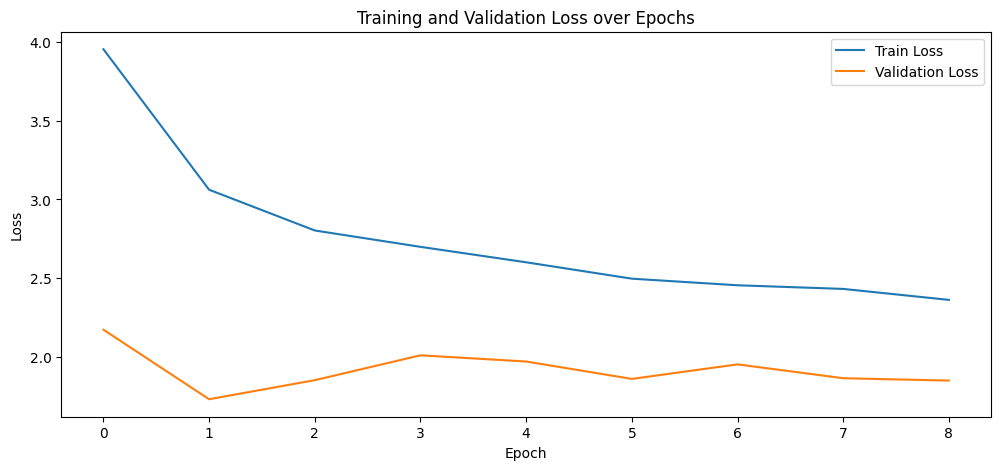

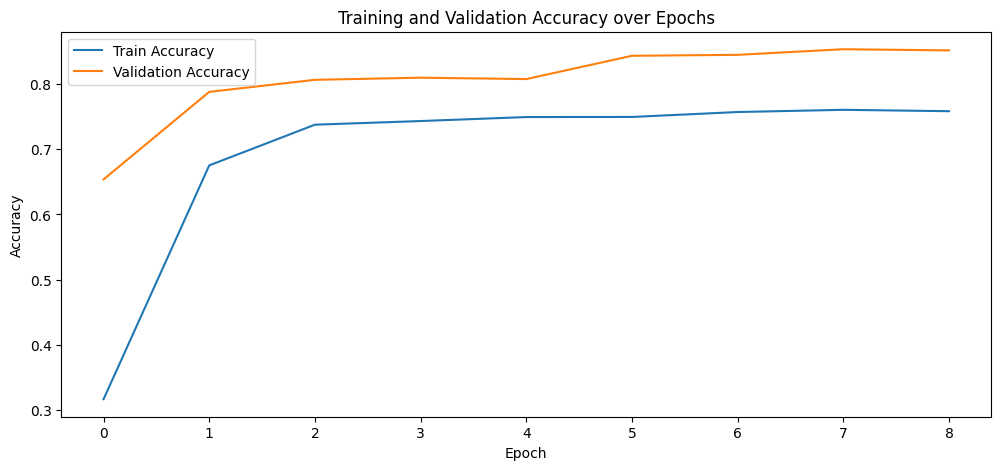

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import timm
import random
import numpy as np
import matplotlib.pyplot as plt

# Channel Attention Module with Dropout
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16, dropout_prob=0.3):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc1(self.global_avg_pool(x))
        avg_out = self.dropout(F.relu(avg_out))
        out = self.fc2(avg_out)
        return x * self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(out)
        return x * self.sigmoid(out)

# Multi-Attention Network with Deeper Attention Layers
class MultiAttentionNetwork(nn.Module):
    def __init__(self, num_classes=102):
        super(MultiAttentionNetwork, self).__init__()
        # Load pretrained Xception from timm with input channels set to 3
        self.backbone = timm.create_model('xception', pretrained=True, in_chans=3)

        # Deeper Attention Modules with Residual Connections
        self.att1 = ChannelAttention(728)
        self.att2 = SpatialAttention()
        self.att3 = ChannelAttention(728)
        self.att4 = SpatialAttention()
        self.att5 = ChannelAttention(728)  # Additional Channel Attention
        self.att6 = SpatialAttention()      # Additional Spatial Attention
        self.att7 = ChannelAttention(728)   # Additional Channel Attention

        # Replace the classifier layer with a new fully connected layer for 102 classes
        self.backbone.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Backbone feature extraction with multiple attention layers
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.act1(x)
        x = self.backbone.conv2(x)
        x = self.backbone.bn2(x)
        x = self.backbone.act2(x)
        x = self.backbone.block1(x)
        x = self.backbone.block2(x)
        x = self.backbone.block3(x)

        # Apply multiple attention layers with residual connections
        x = self.att1(x) + x  # Residual Connection
        x = self.att2(x) + x  # Residual Connection
        x = self.backbone.block4(x)
        x = self.backbone.block5(x)
        x = self.backbone.block6(x)
        x = self.backbone.block7(x)

        x = self.att3(x) + x  # Residual Connection
        x = self.att4(x) + x  # Residual Connection
        x = self.backbone.block8(x)

        x = self.att5(x) + x  # New Channel Attention
        x = self.att6(x) + x  # New Spatial Attention
        x = self.backbone.block9(x)

        x = self.att7(x) + x  # Additional Channel Attention

        # Final layers
        x = self.backbone.block10(x)
        x = self.backbone.block11(x)
        x = self.backbone.block12(x)
        x = self.backbone.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.backbone.fc(x)

# Mixed Loss to handle augmented labels
class MixedLoss(nn.Module):
    def __init__(self):
        super(MixedLoss, self).__init__()
        self.softmax_loss = nn.CrossEntropyLoss()

    def forward(self, logits, label_a, label_b, lam):
        lam = lam.to(logits.device)
        return (lam * self.softmax_loss(logits, label_a) + (1 - lam) * self.softmax_loss(logits, label_b)).mean()

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_val_loss is None or val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Model, criterion, optimizer, and scheduler setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiAttentionNetwork(num_classes=102).to(device)
criterion = MixedLoss()
optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
early_stopping = EarlyStopping(patience=7)

# Lists to track metrics
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# Training function for augmented data with MixUp/CutMix
def train_epoch_augmented(model, train_loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for images, label_a, label_b, lam in train_loader:
        images, label_a, label_b = images.to(device), label_a.to(device), label_b.to(device)
        lam = lam.to(device) if torch.is_tensor(lam) else torch.tensor([lam], device=device)

        if lam.dim() == 0:
            lam = lam.expand(images.size(0)).to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, label_a, label_b, lam)
        loss.backward()
        optimizer.step()

        _, predicted = logits.max(1)
        min_size = min(predicted.size(0), label_a.size(0), label_b.size(0), lam.size(0))
        predicted, label_a, label_b, lam = predicted[:min_size], label_a[:min_size], label_b[:min_size], lam[:min_size]

        total_loss += loss.item() * images.size(0)
        correct += (predicted.eq(label_a) * lam + predicted.eq(label_b) * (1 - lam)).sum().item()

    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(test_loader.dataset), correct / len(test_loader.dataset)

# Training Loop with Early Stopping
num_epochs = 20
best_val_acc = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_augmented(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, nn.CrossEntropyLoss())
    scheduler.step()

    # Append metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_flower_model.pth')
        print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Test evaluation
test_loss, test_accuracy = evaluate(model, test_loader, nn.CrossEntropyLoss())
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

<Figure size 5000x5000 with 0 Axes>

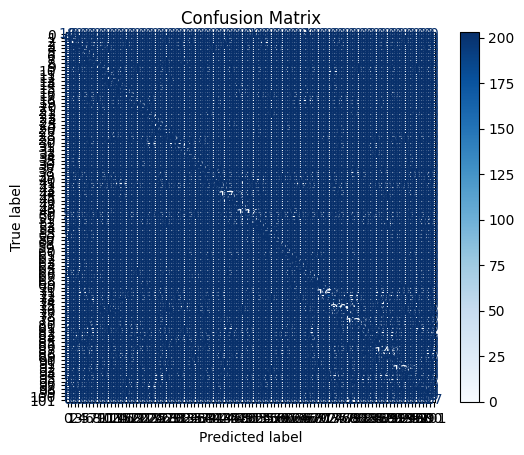

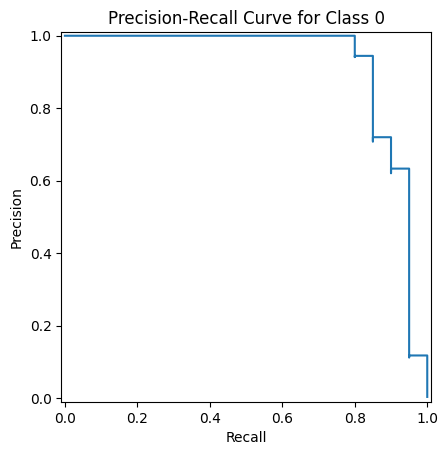

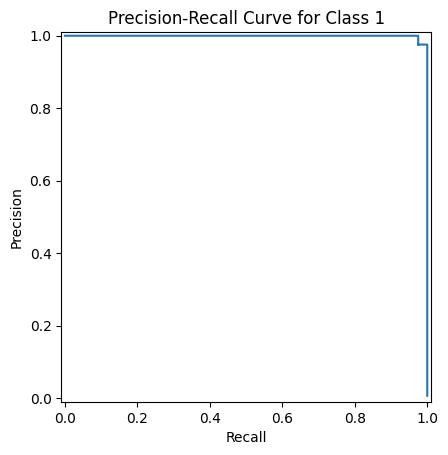

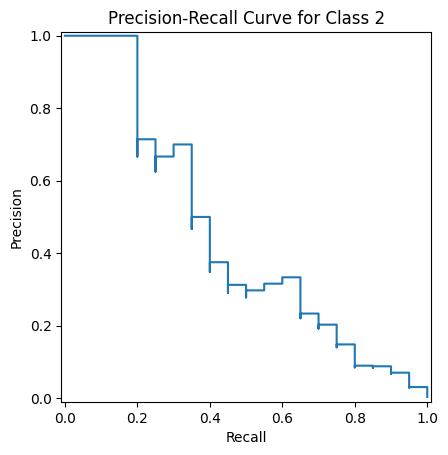

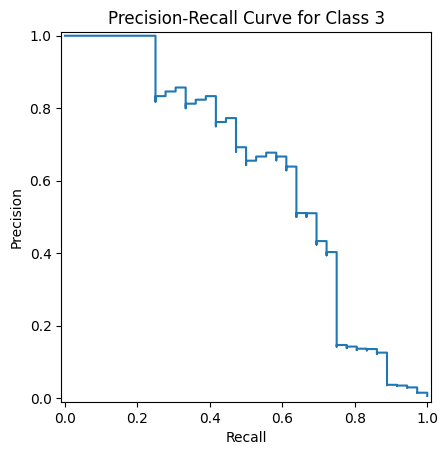

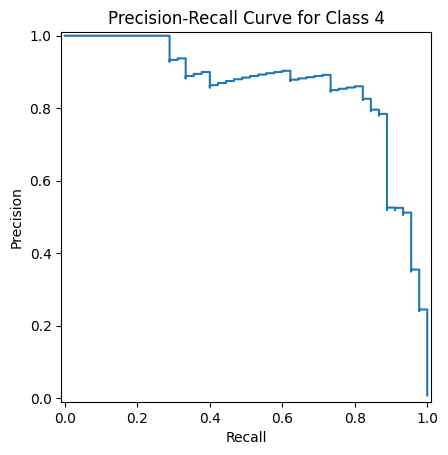

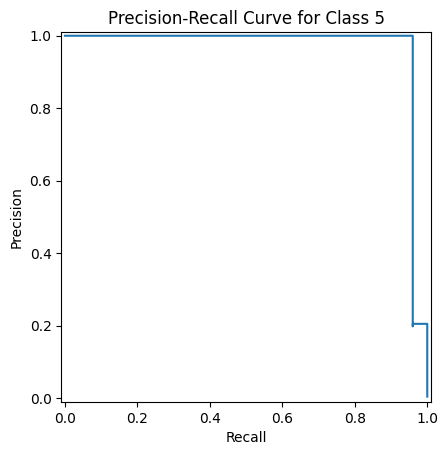

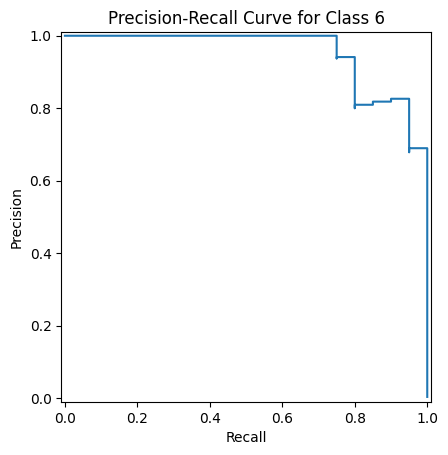

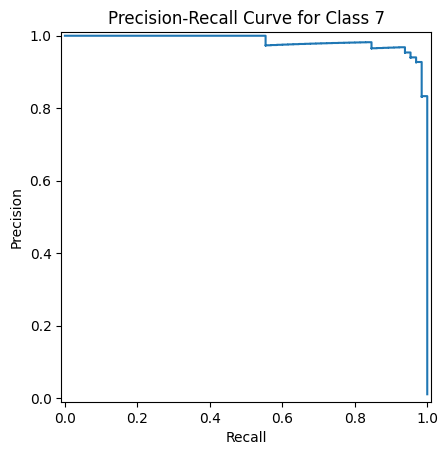

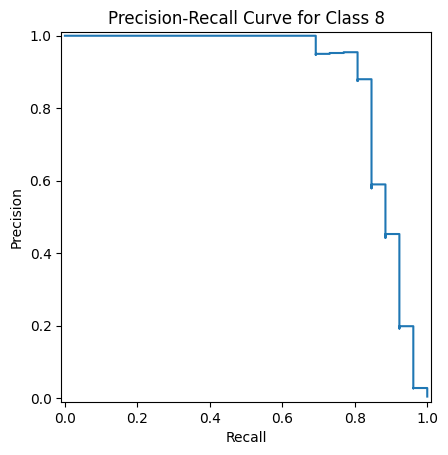

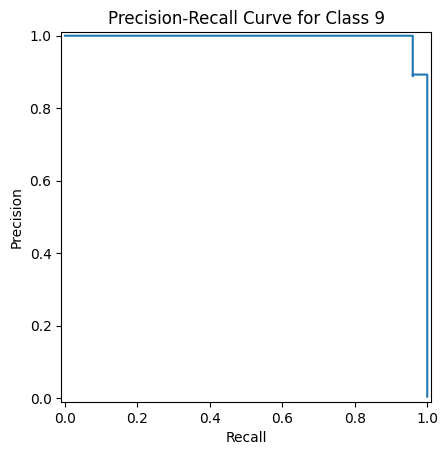

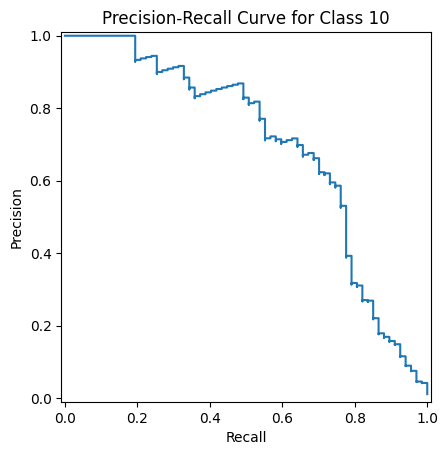

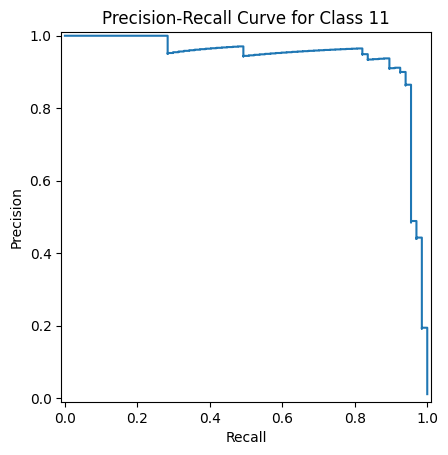

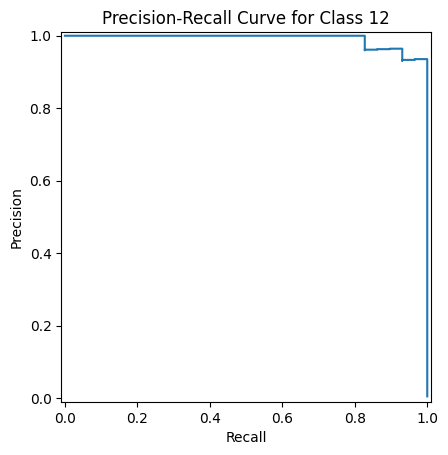

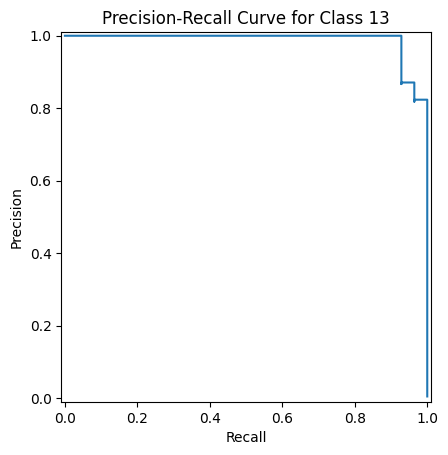

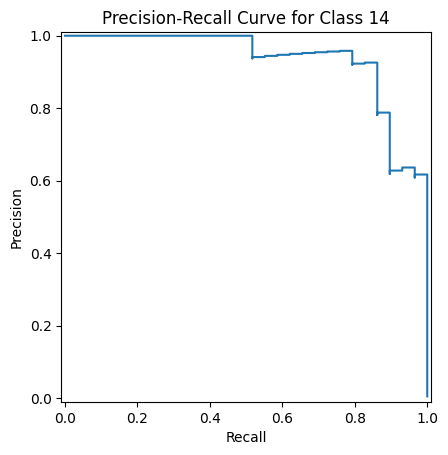

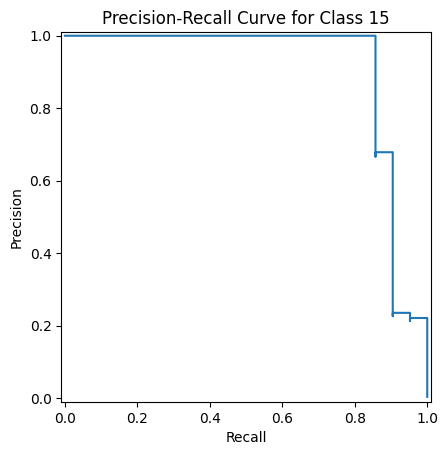

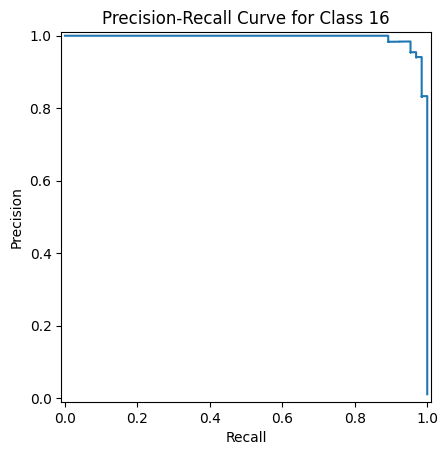

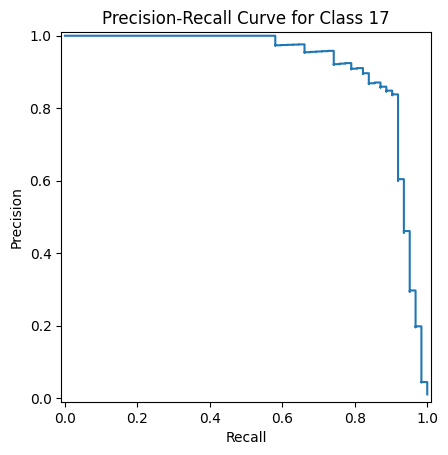

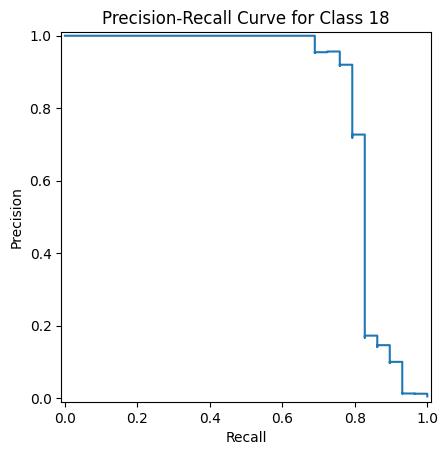

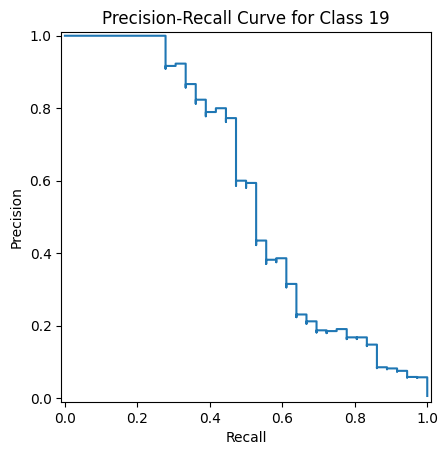

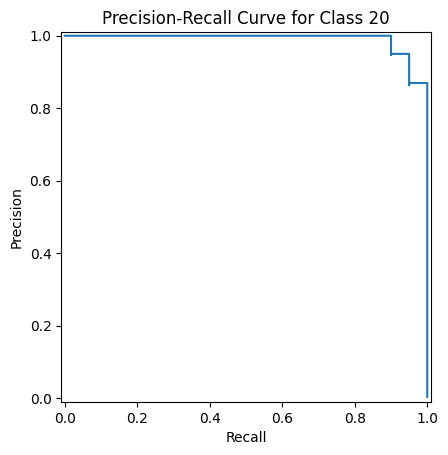

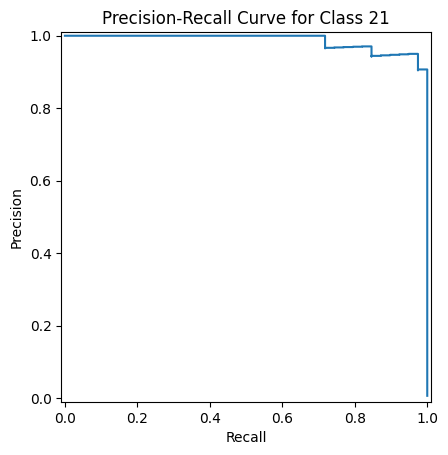

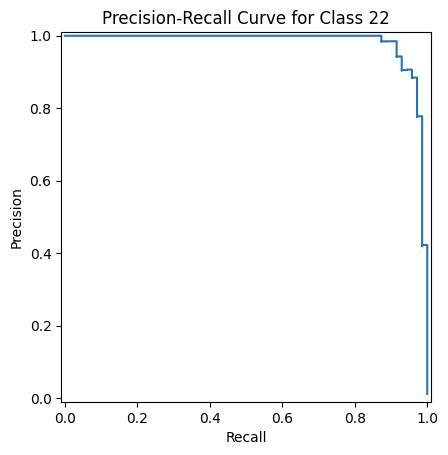

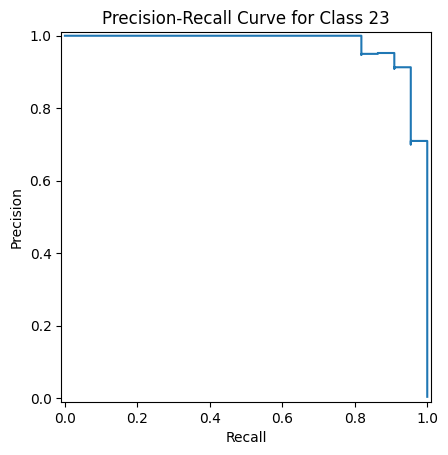

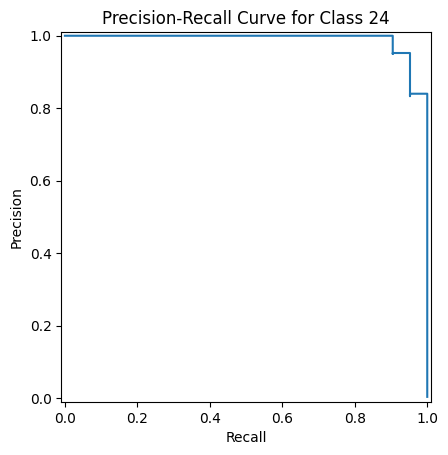

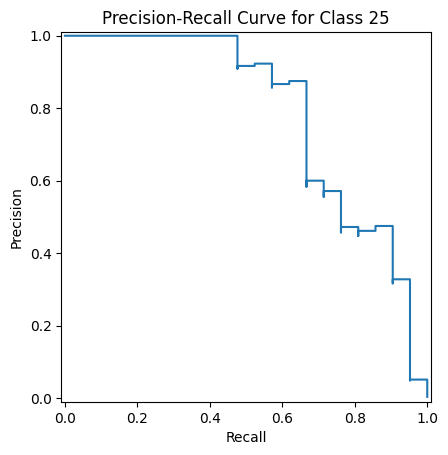

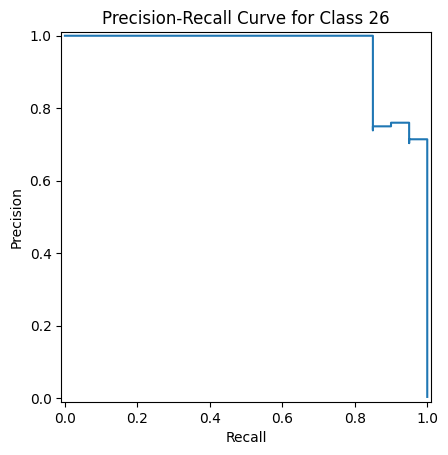

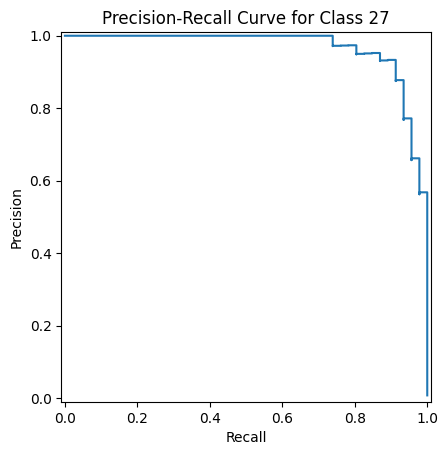

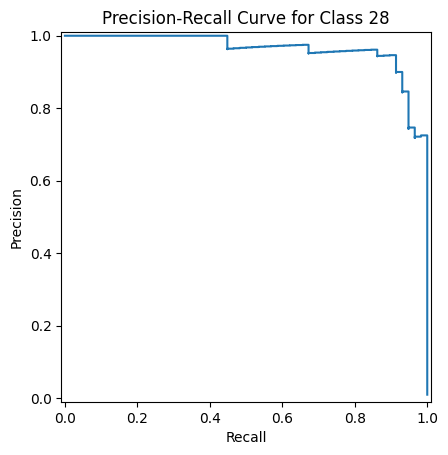

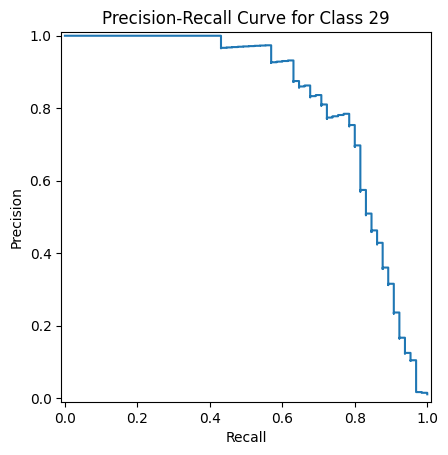

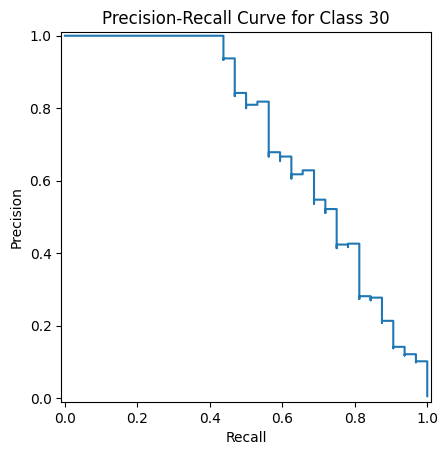

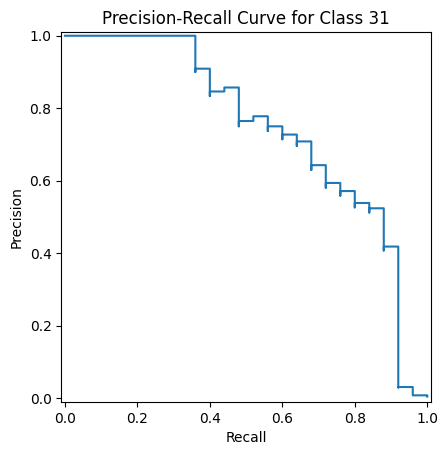

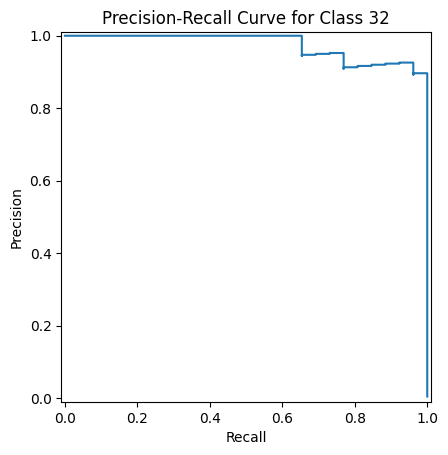

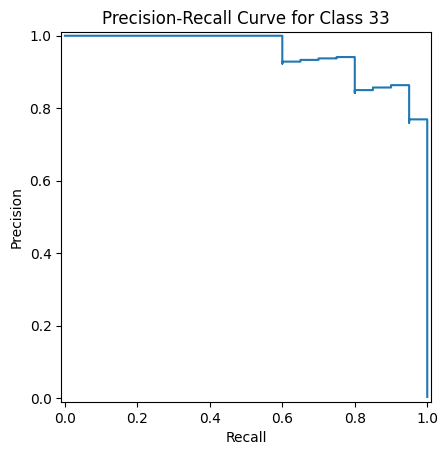

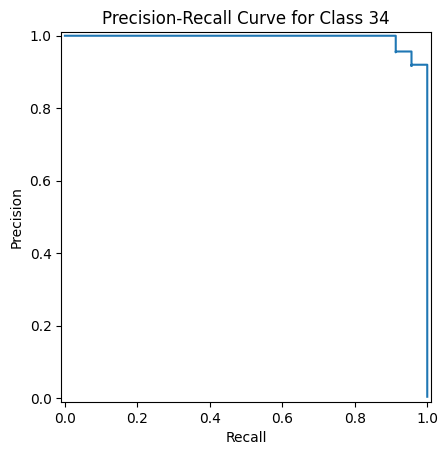

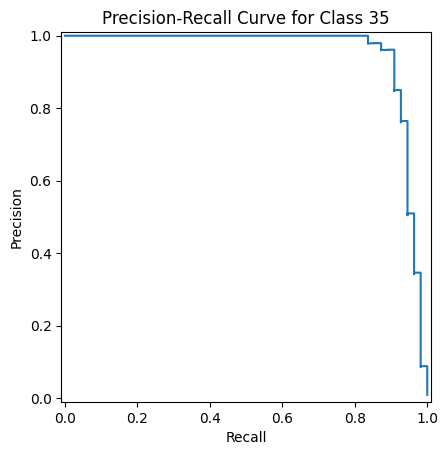

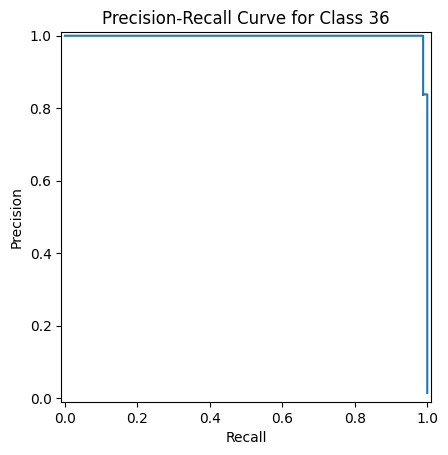

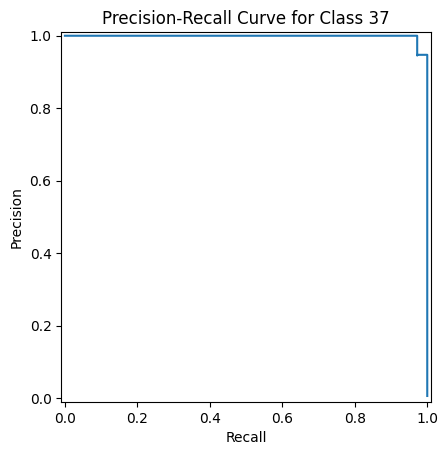

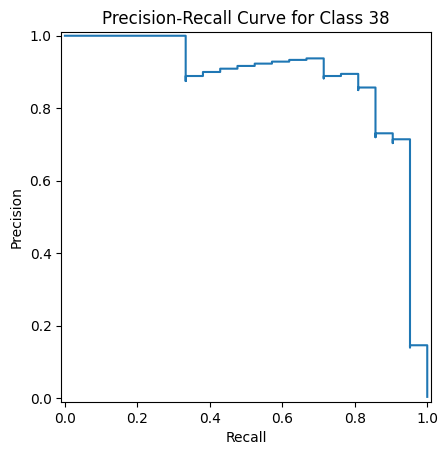

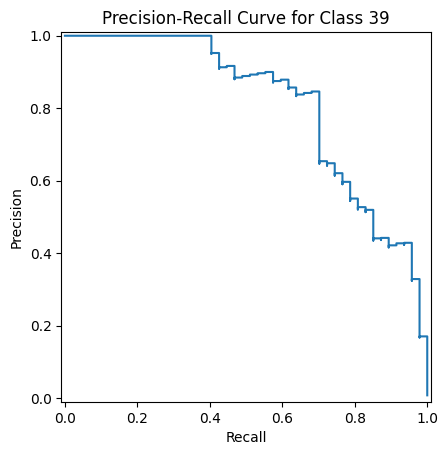

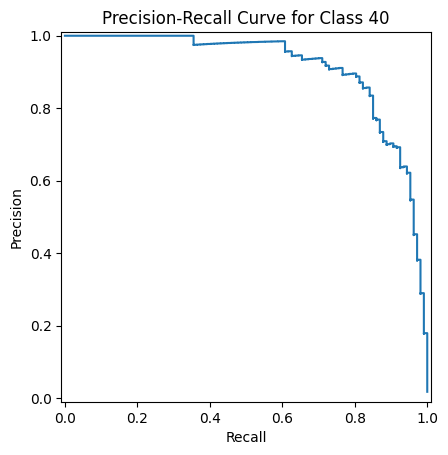

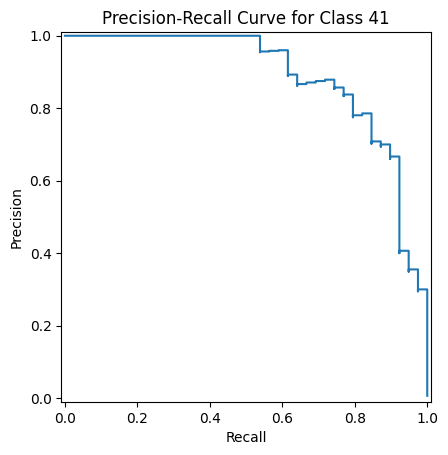

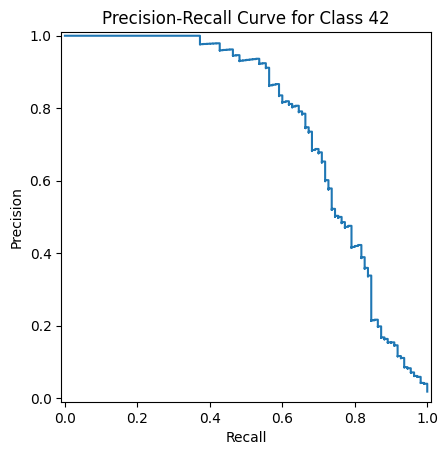

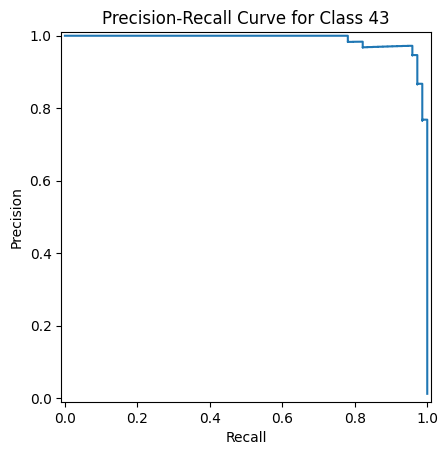

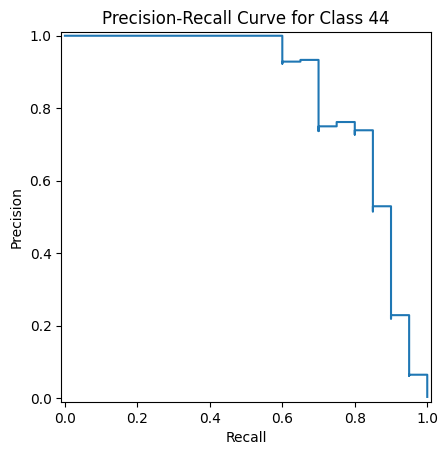

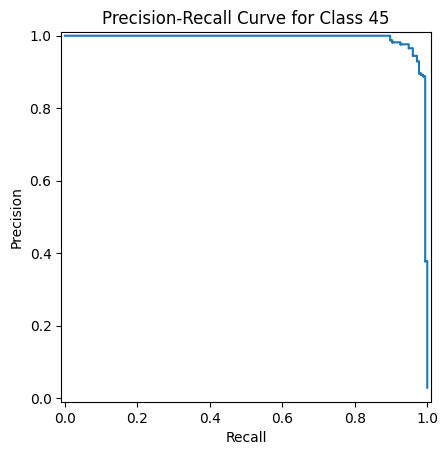

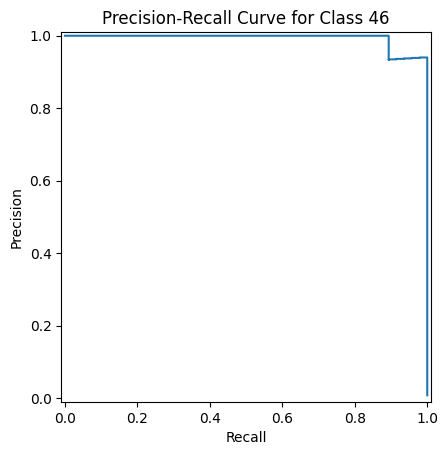

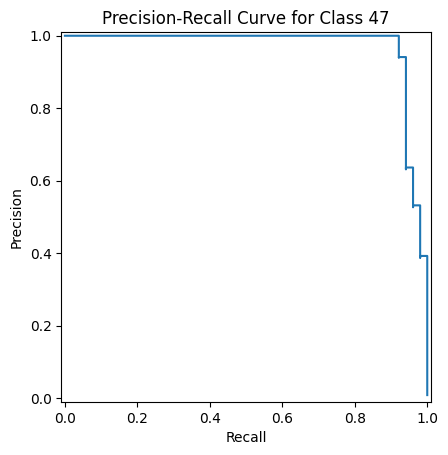

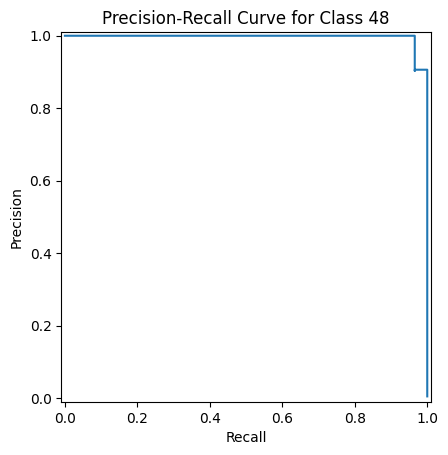

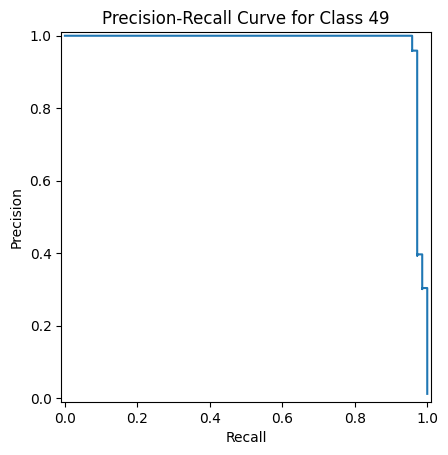

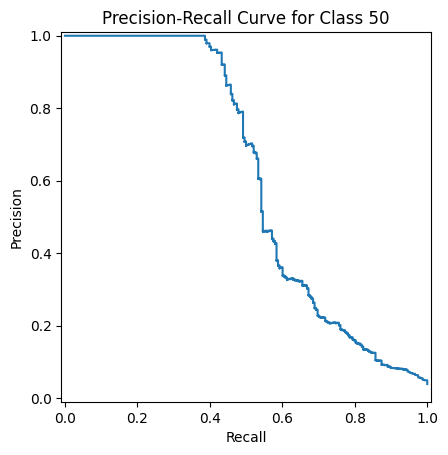

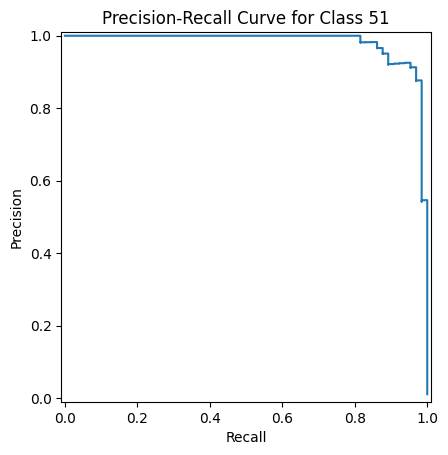

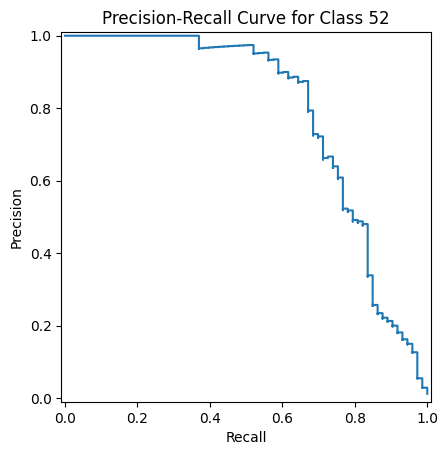

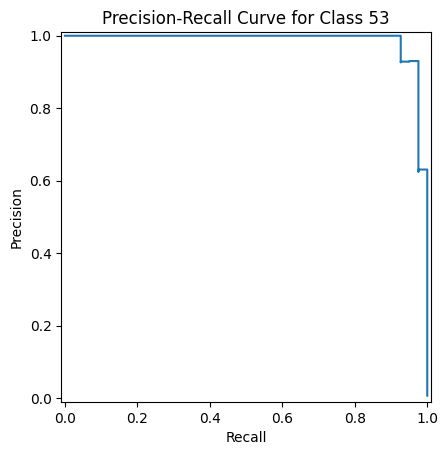

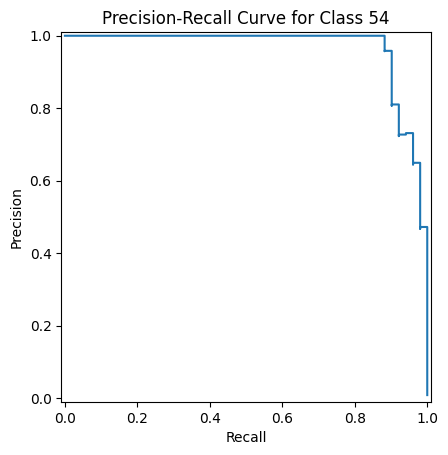

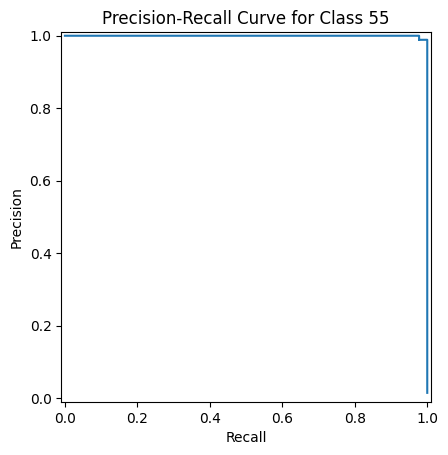

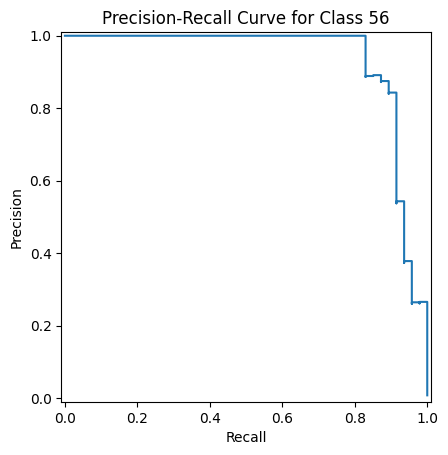

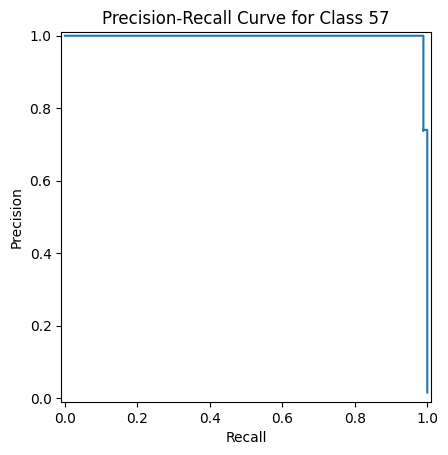

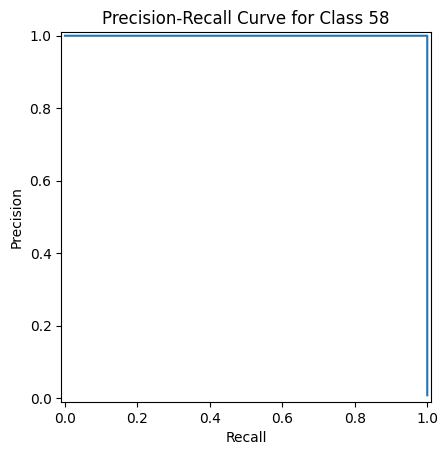

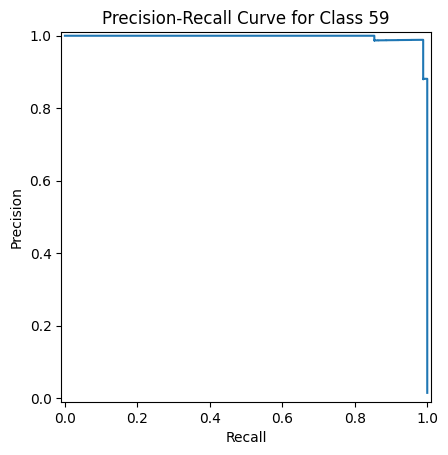

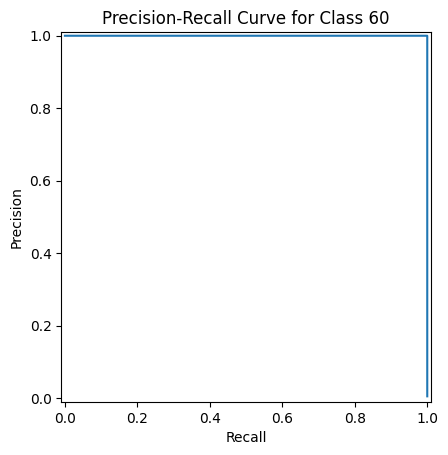

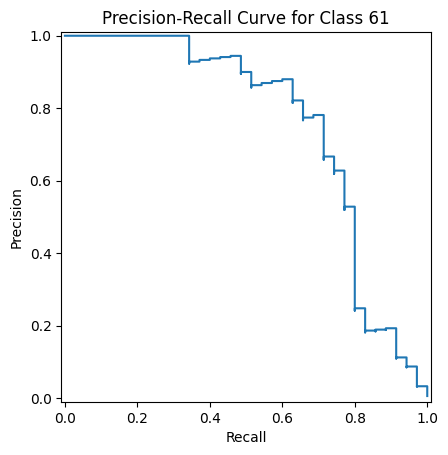

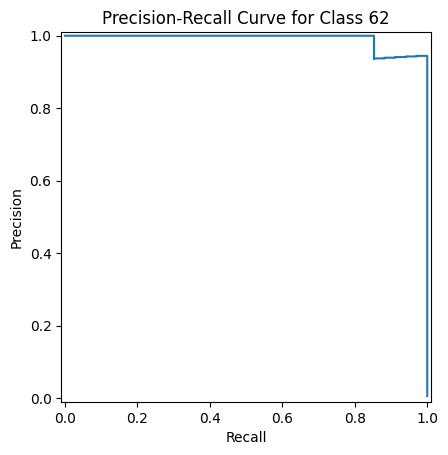

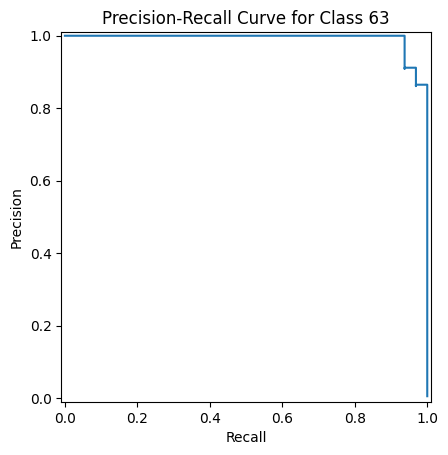

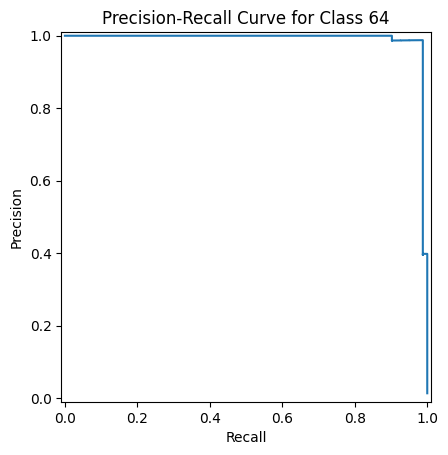

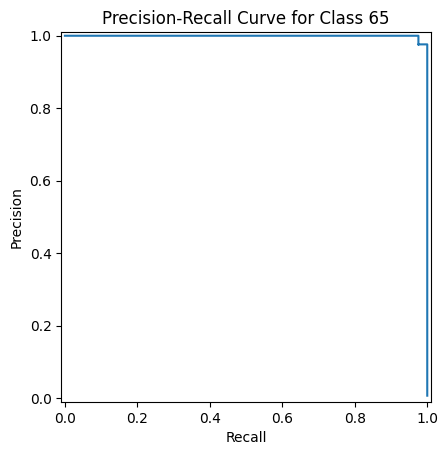

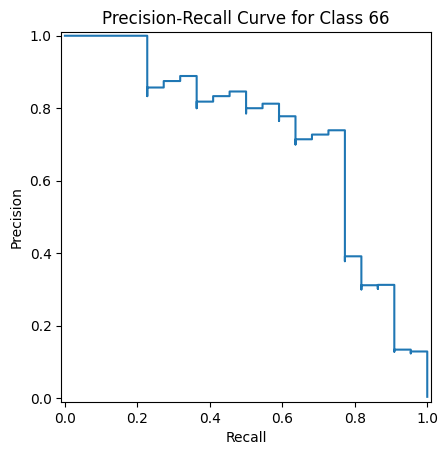

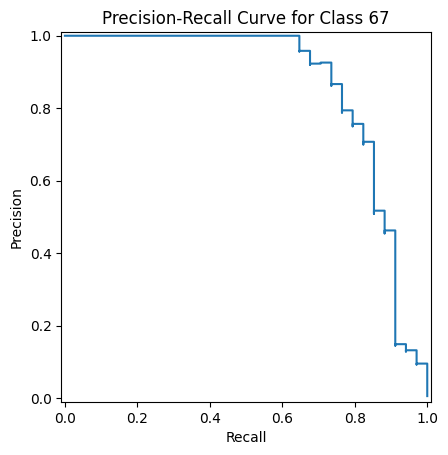

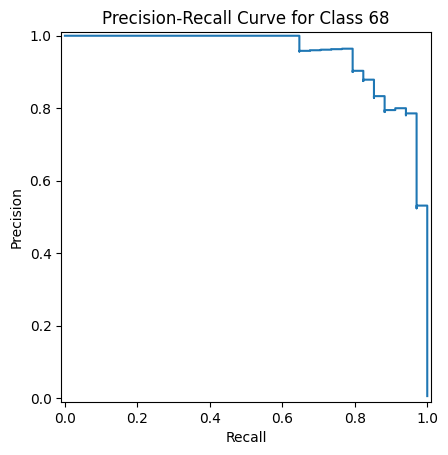

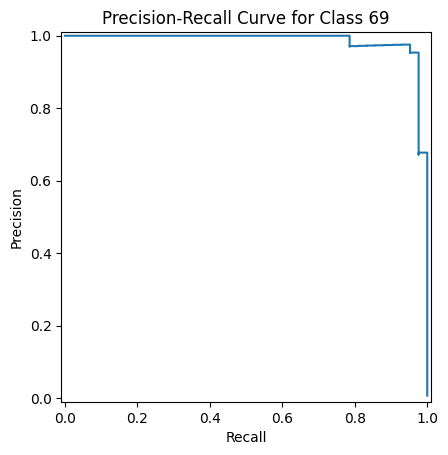

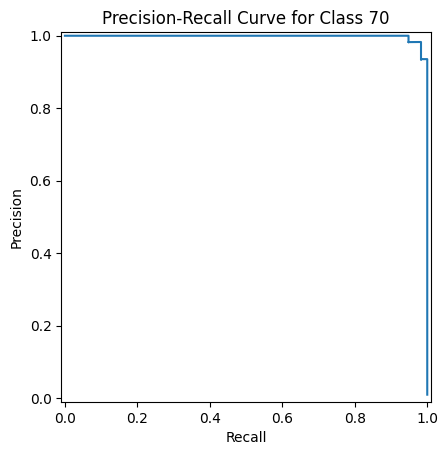

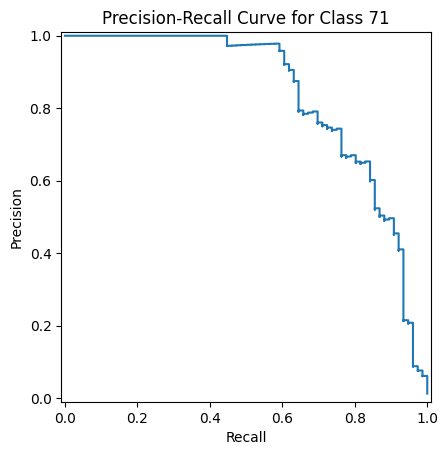

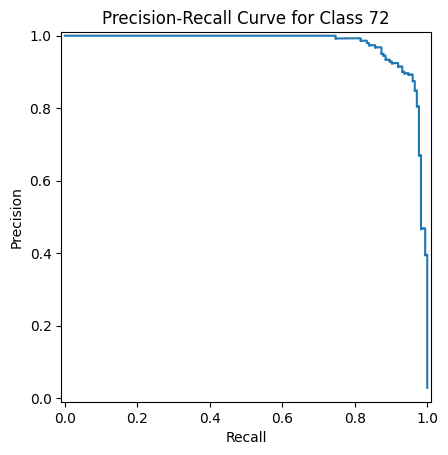

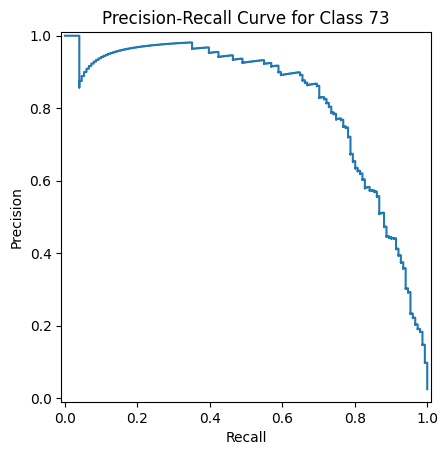

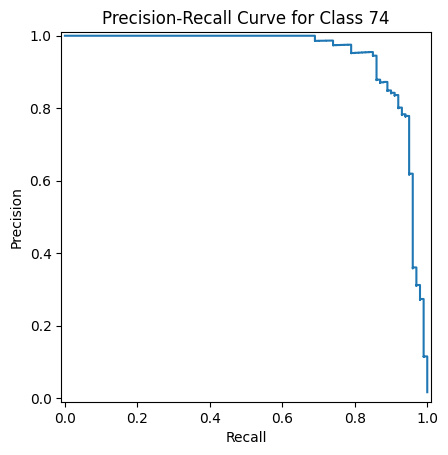

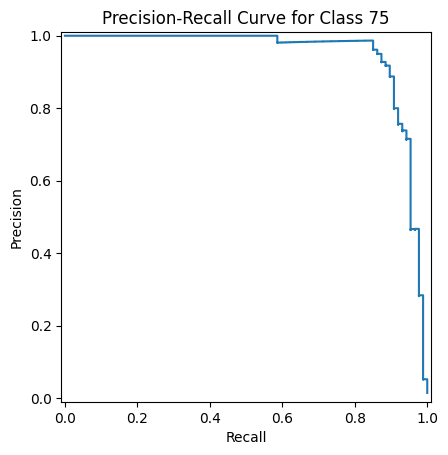

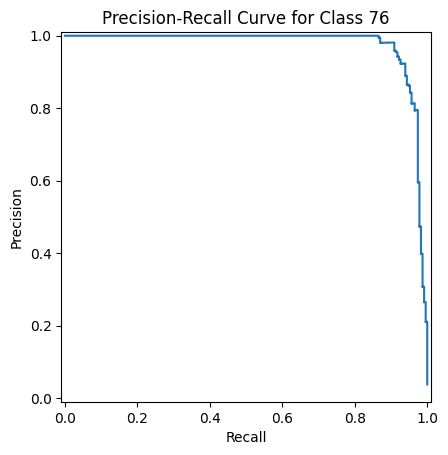

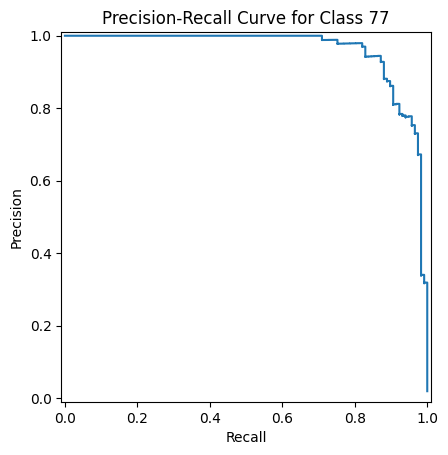

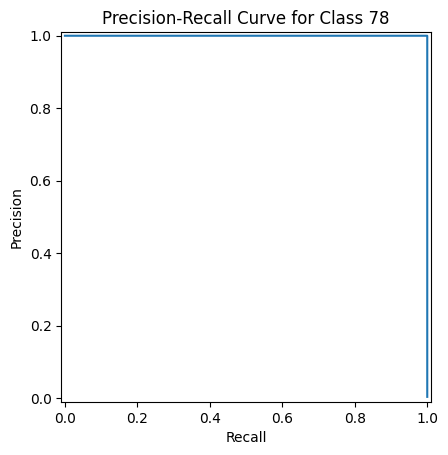

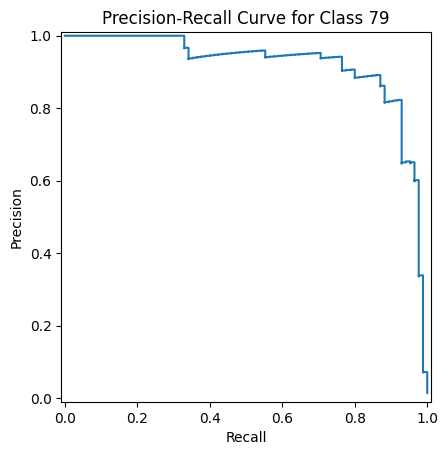

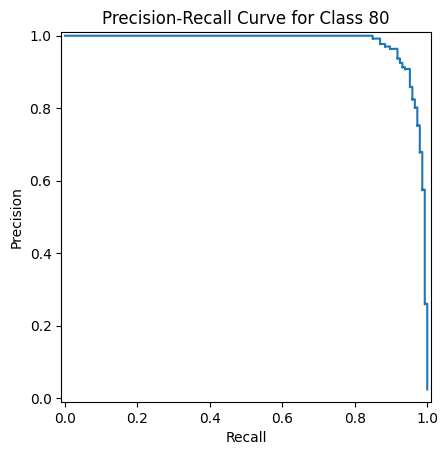

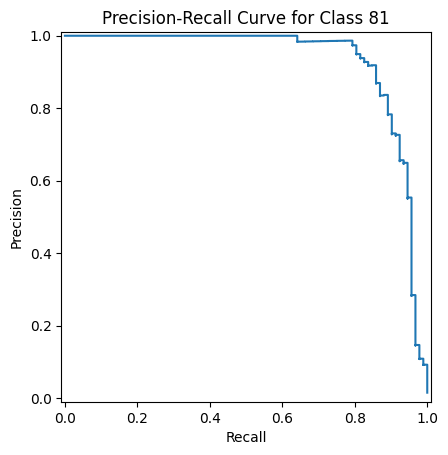

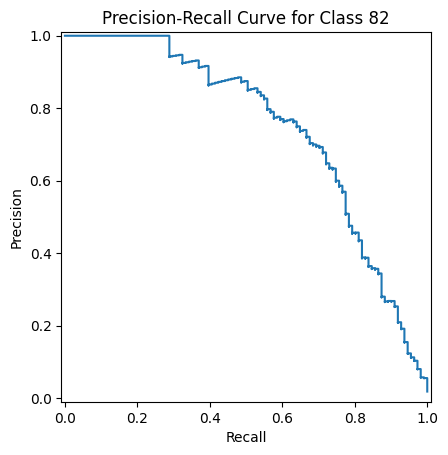

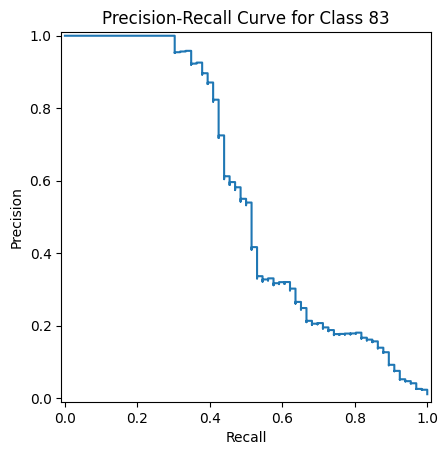

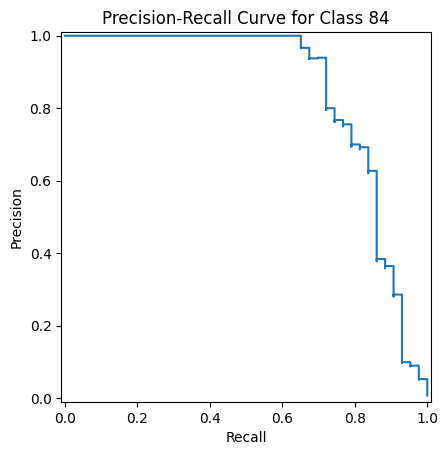

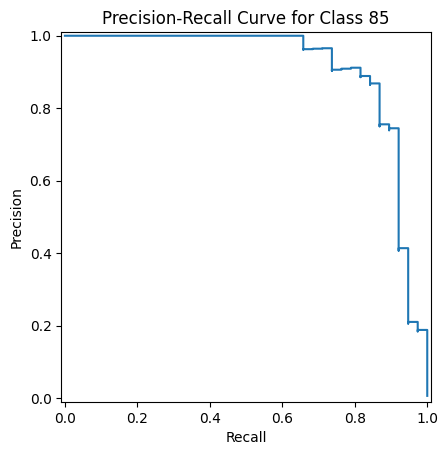

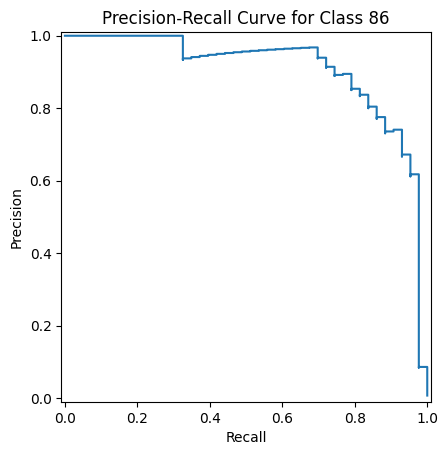

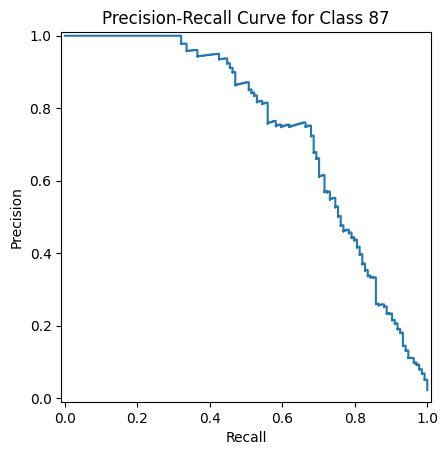

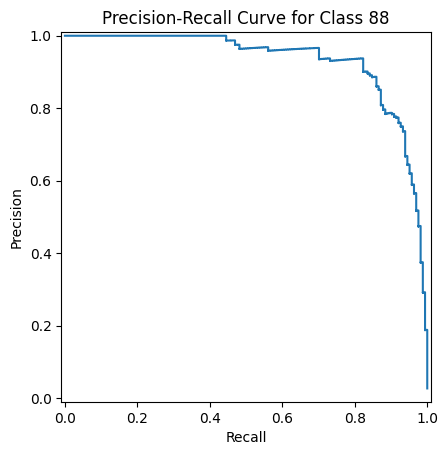

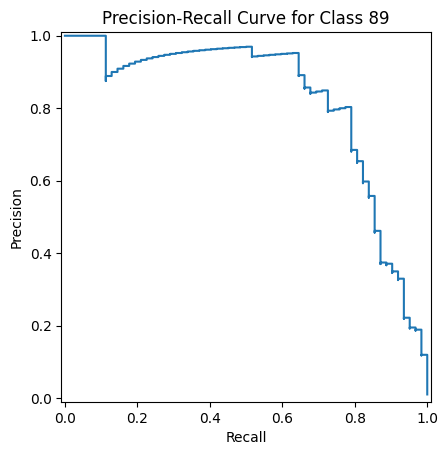

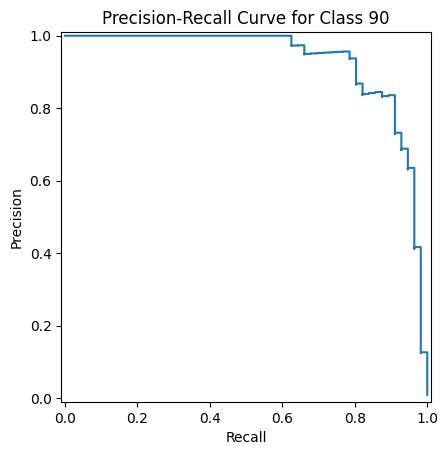

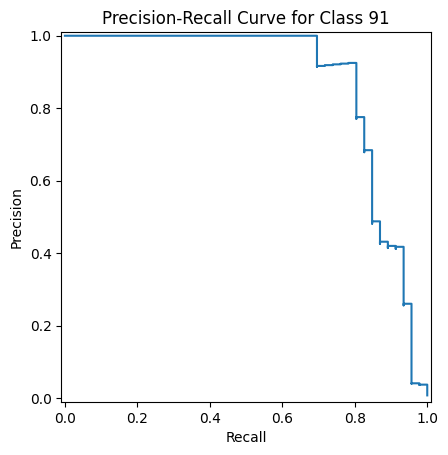

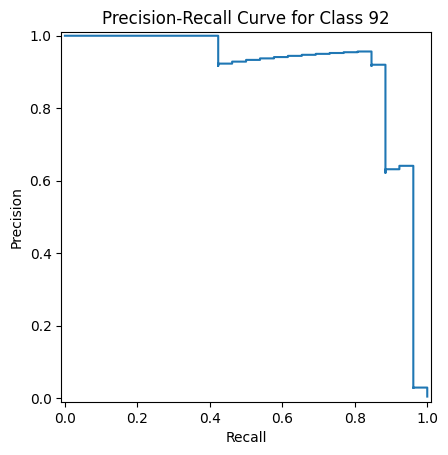

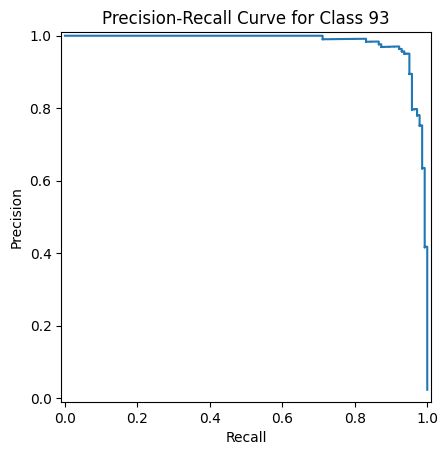

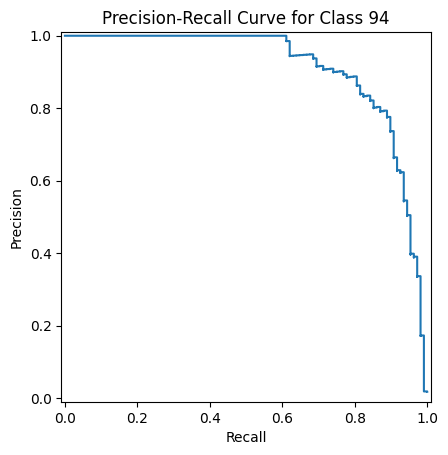

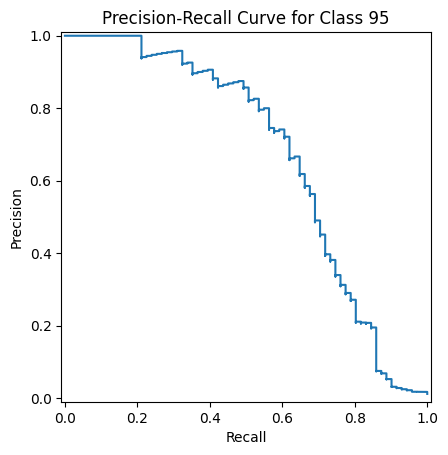

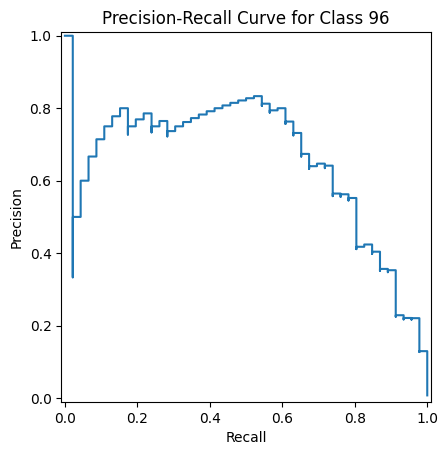

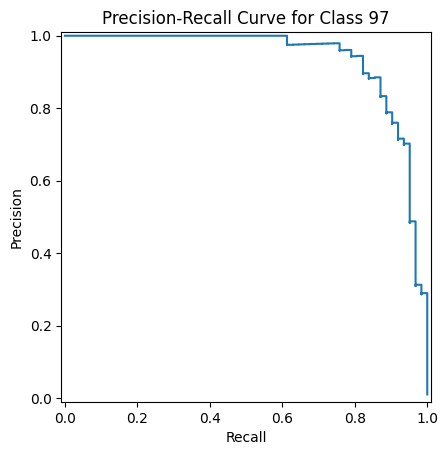

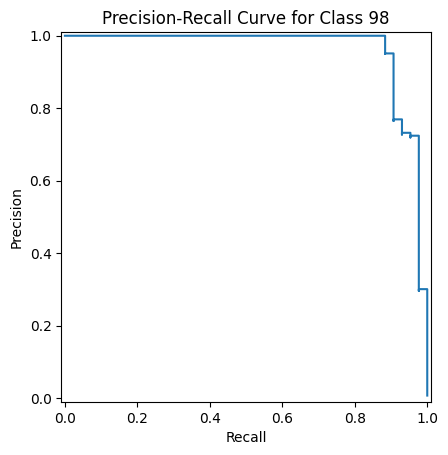

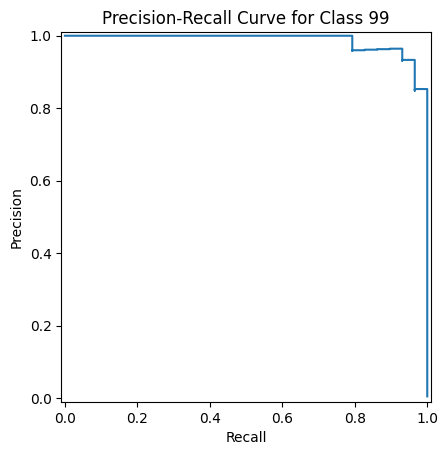

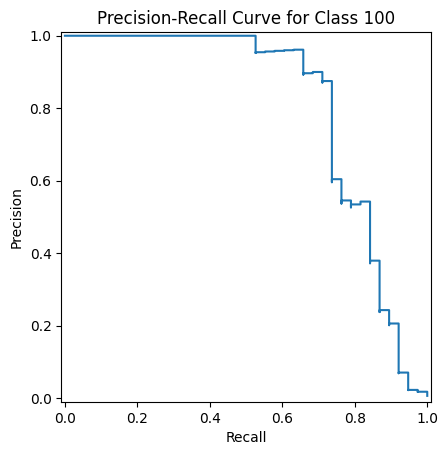

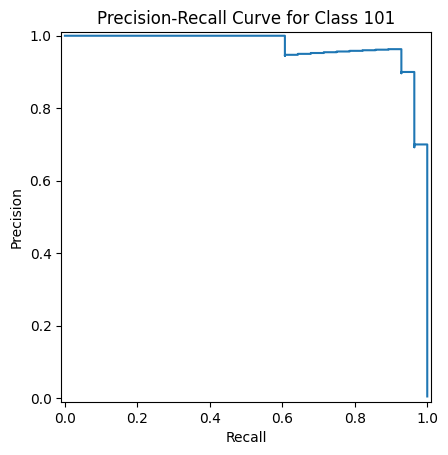

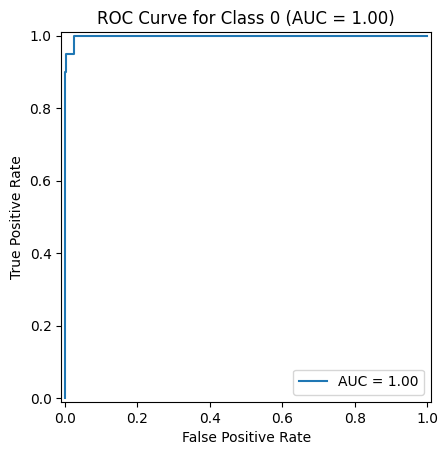

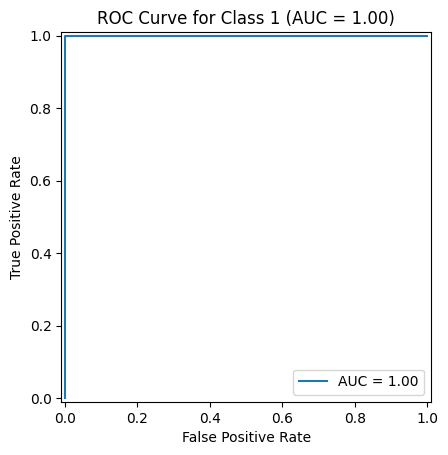

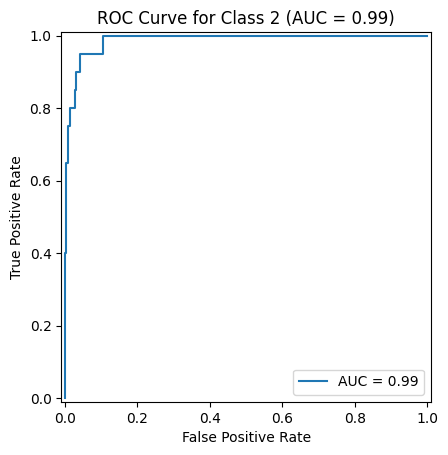

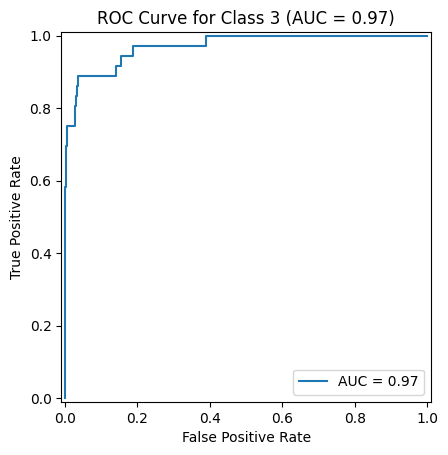

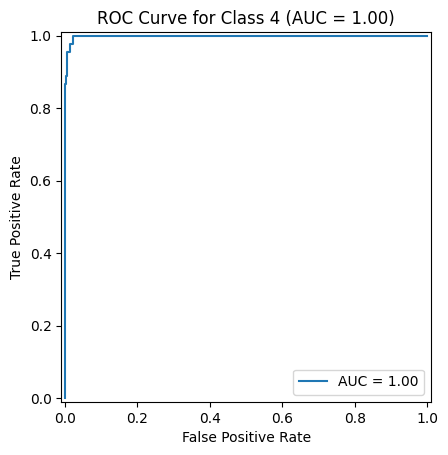

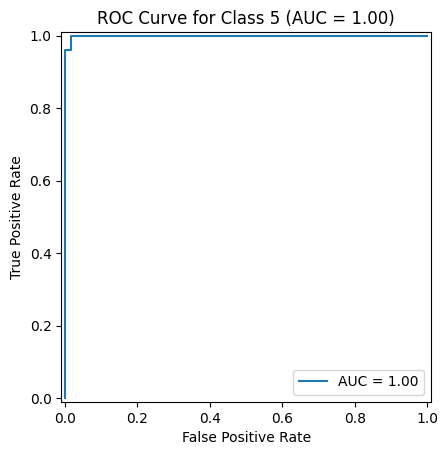

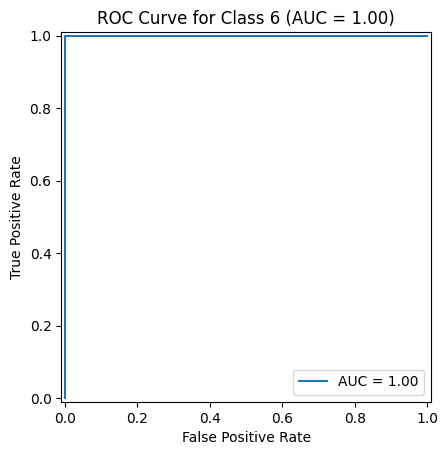

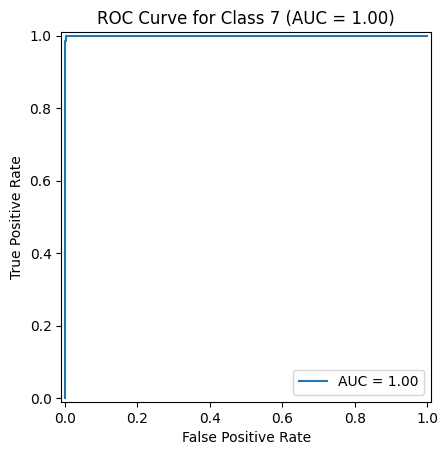

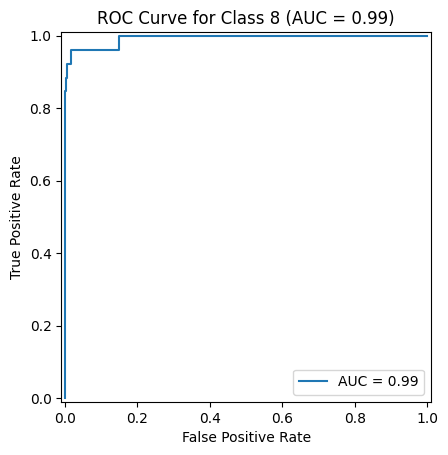

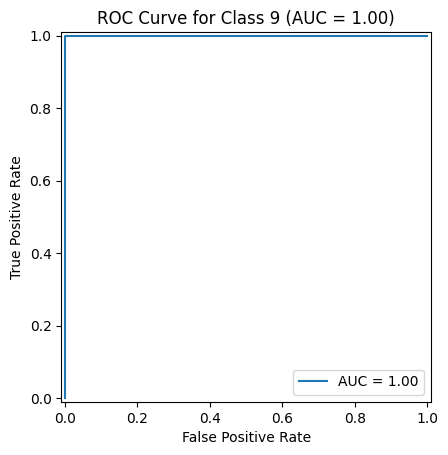

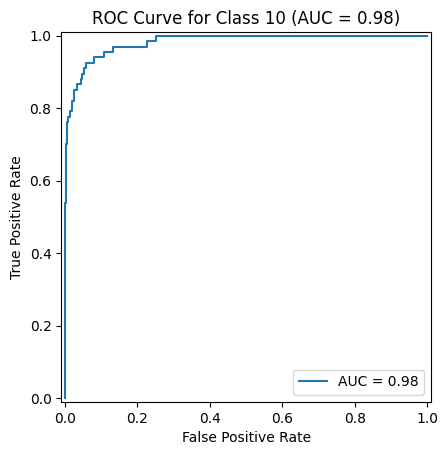

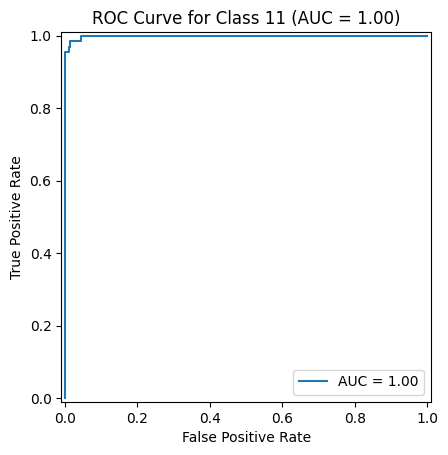

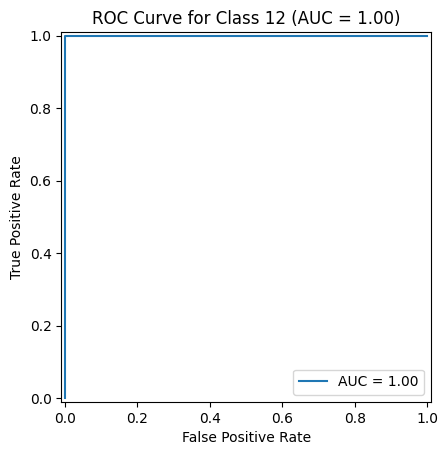

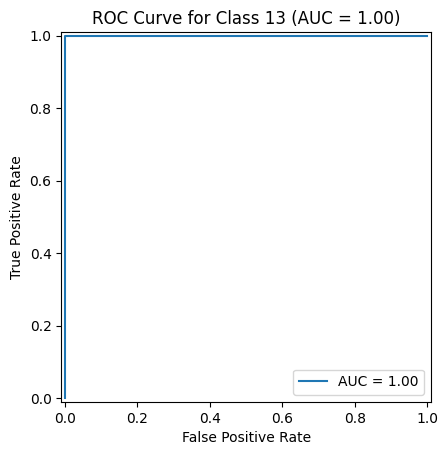

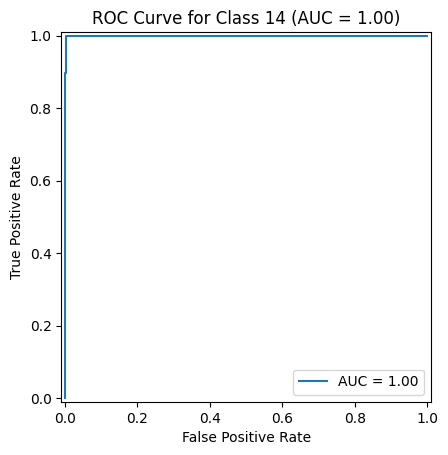

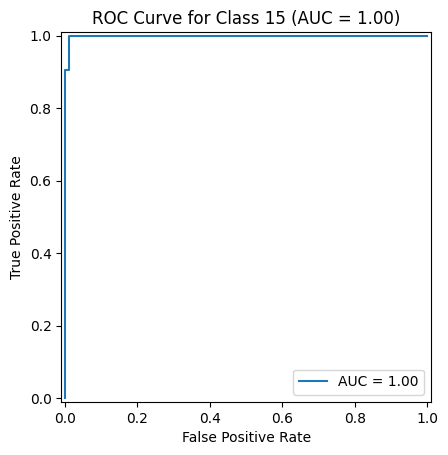

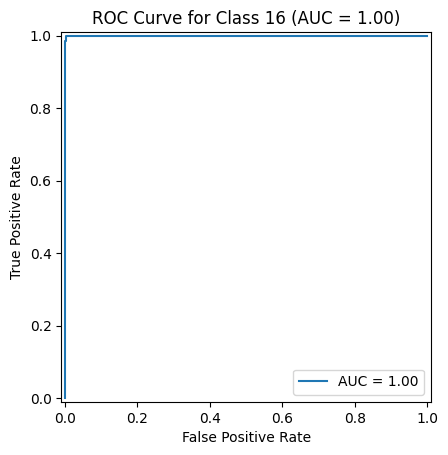

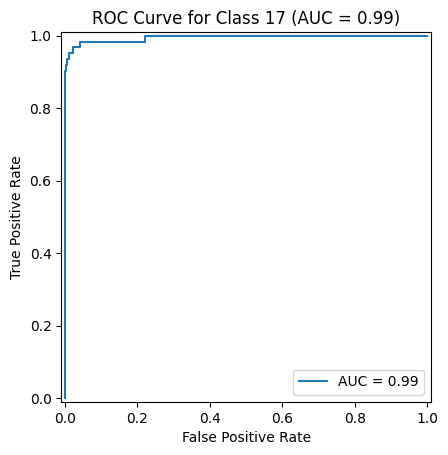

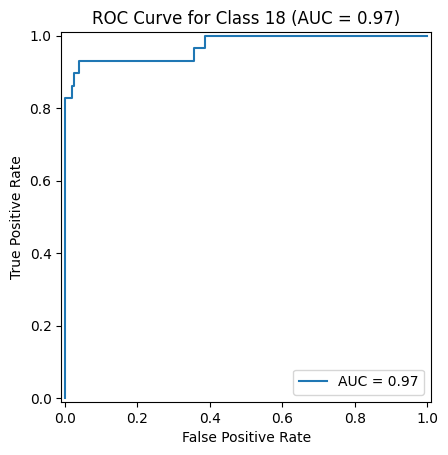

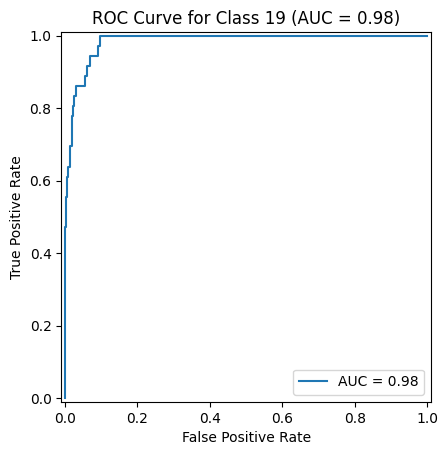

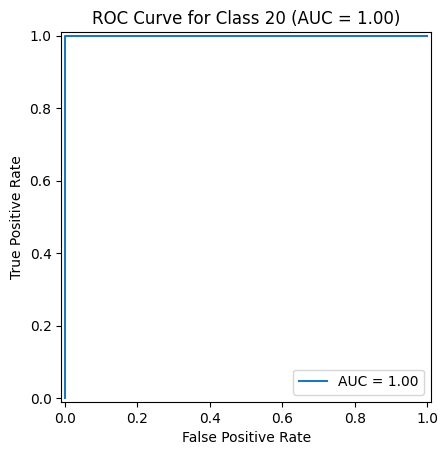

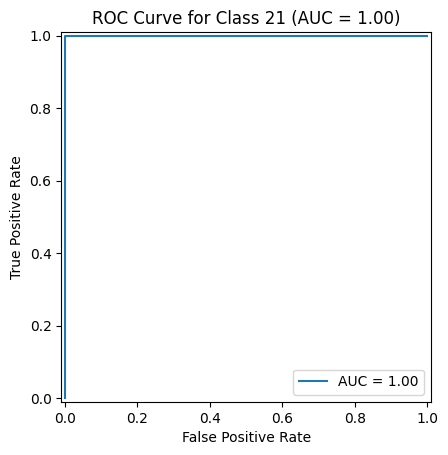

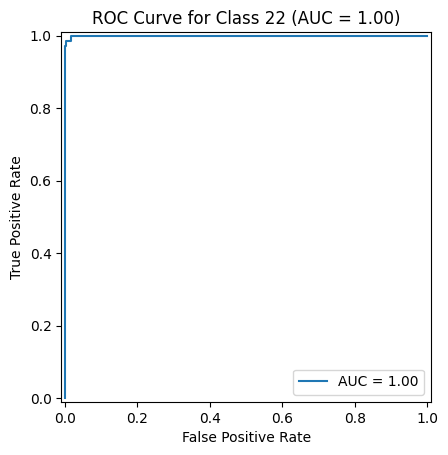

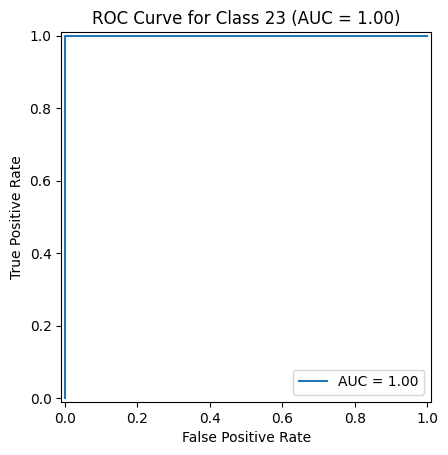

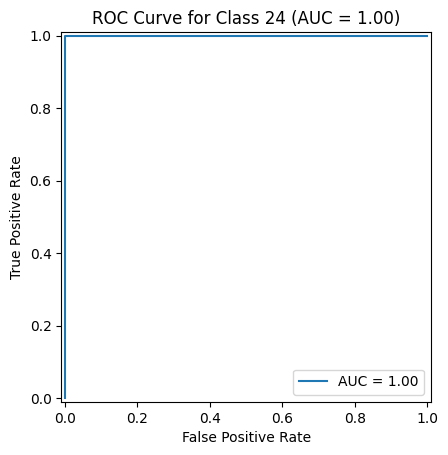

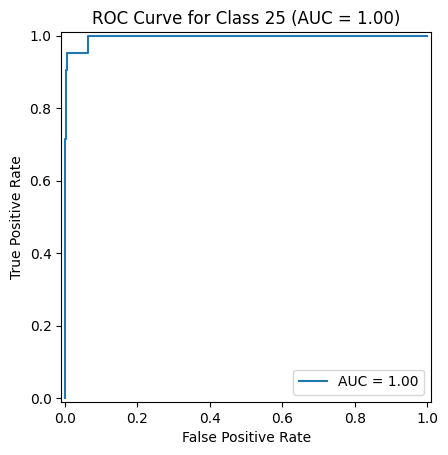

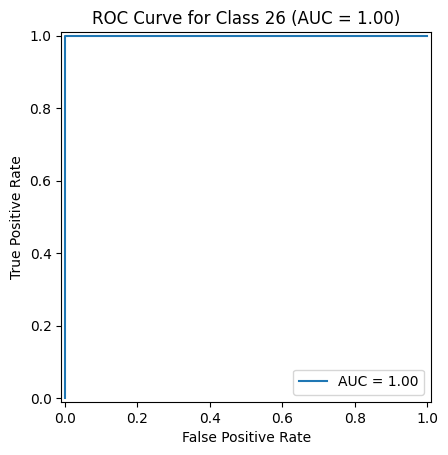

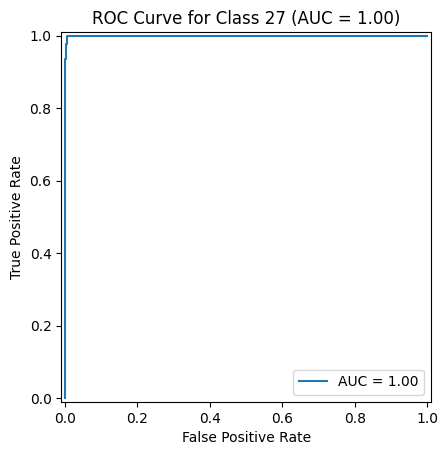

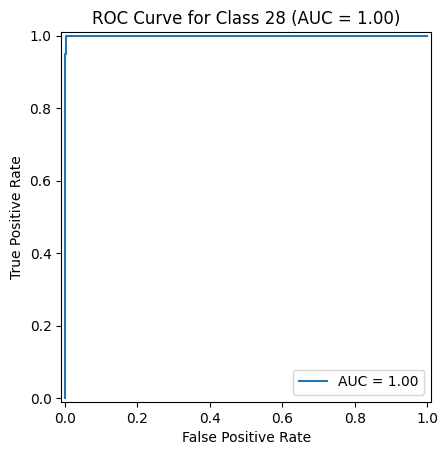

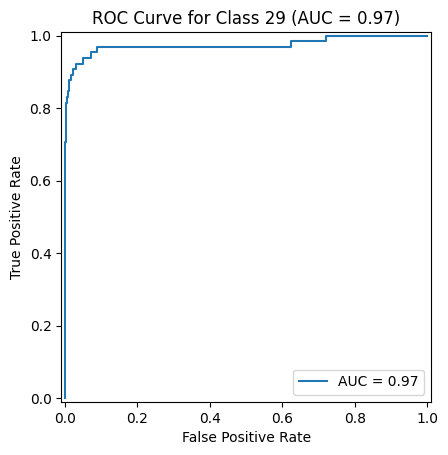

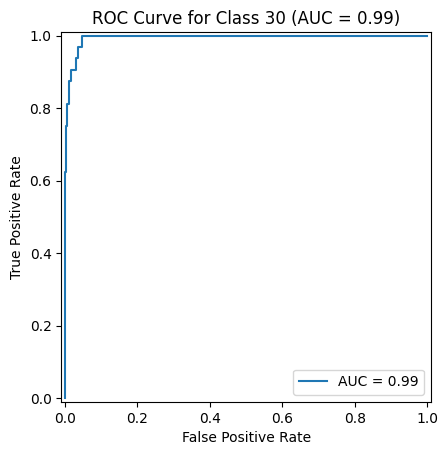

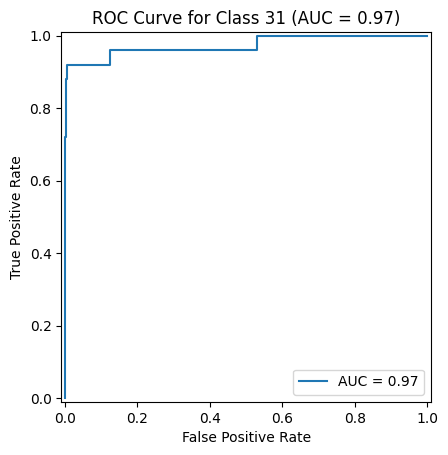

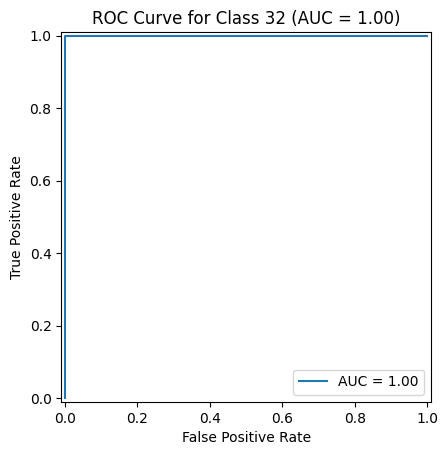

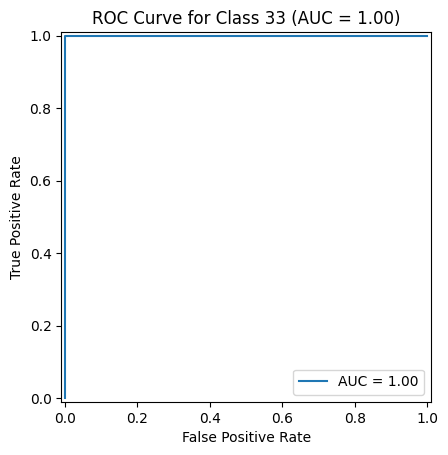

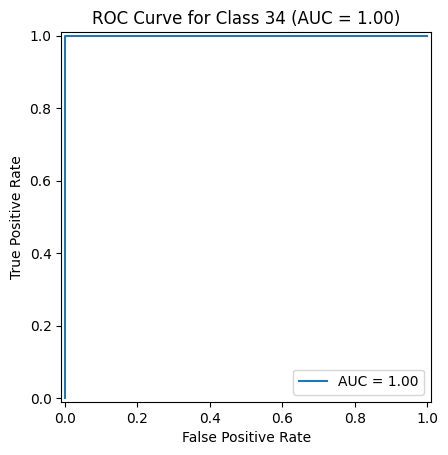

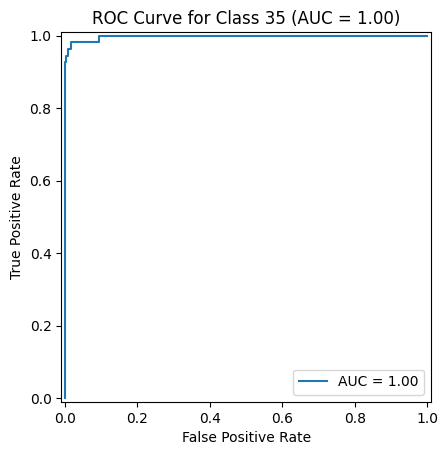

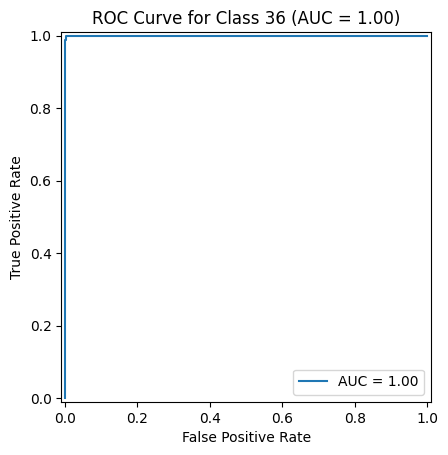

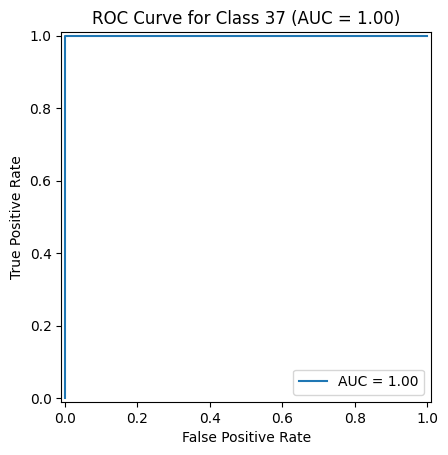

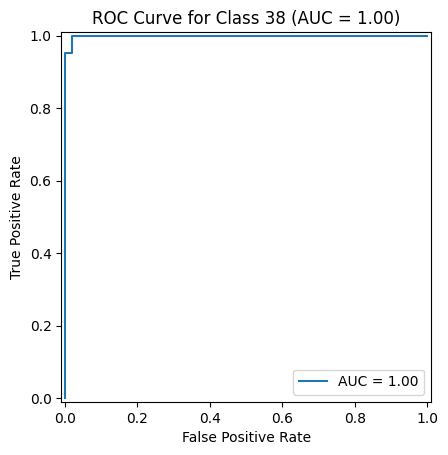

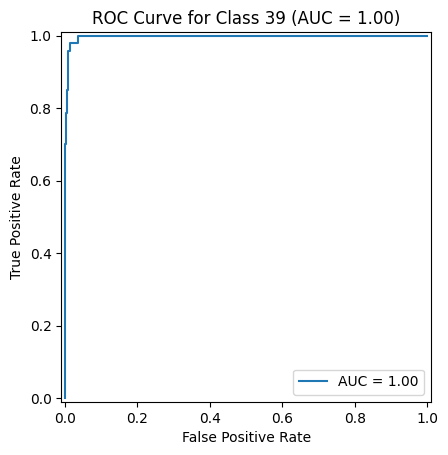

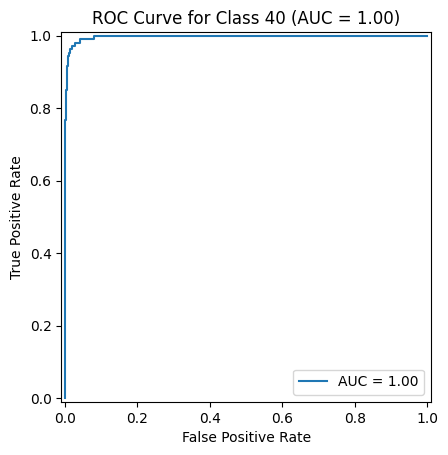

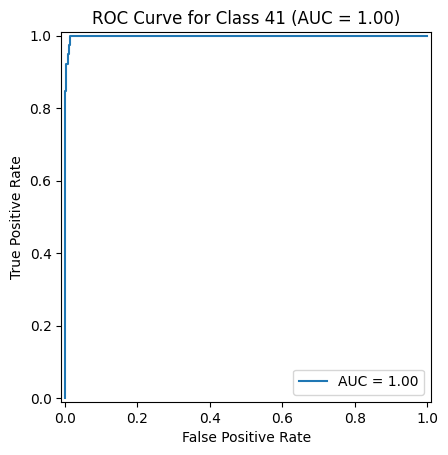

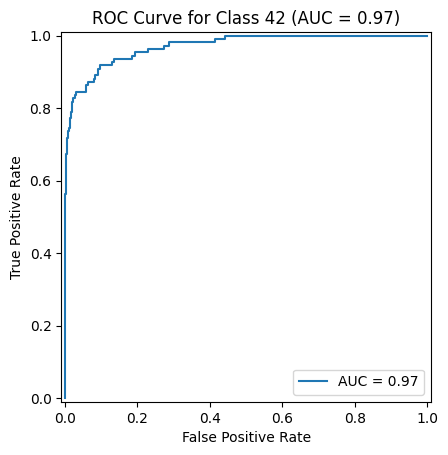

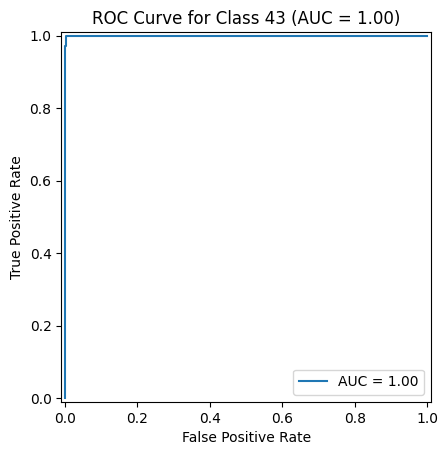

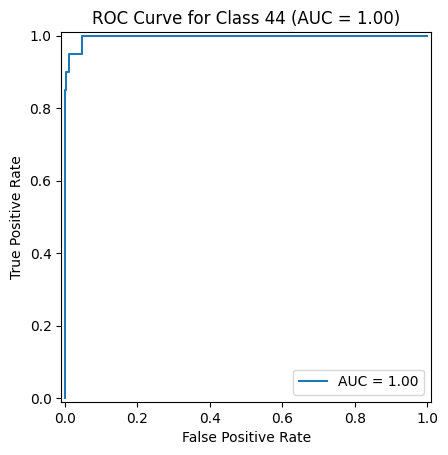

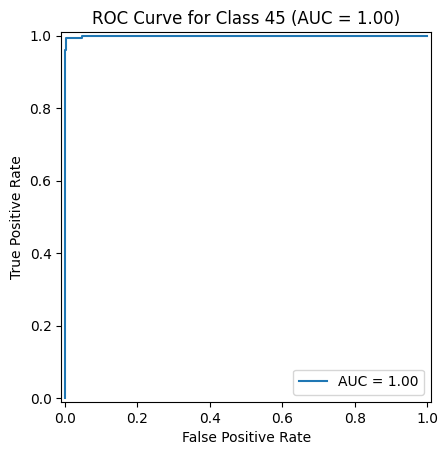

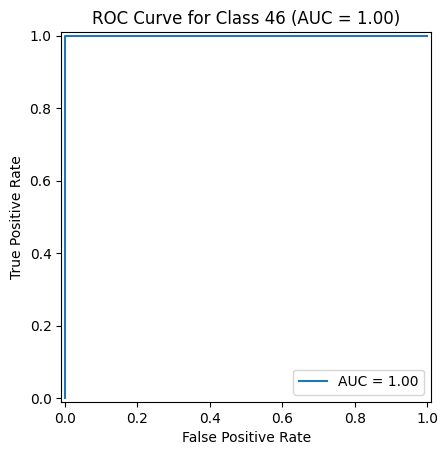

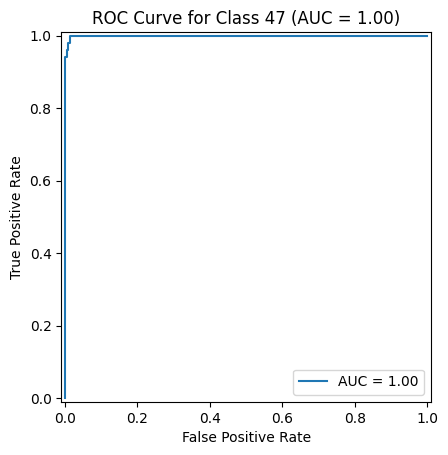

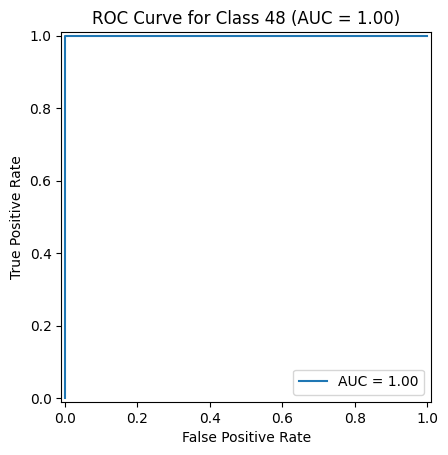

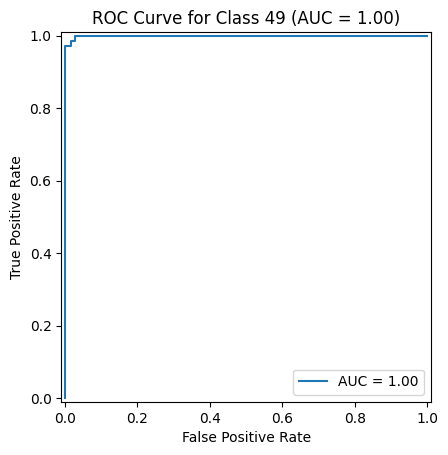

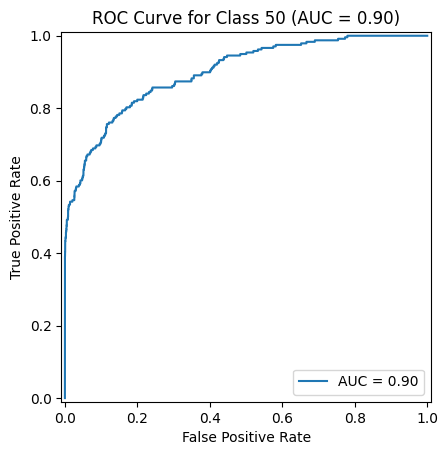

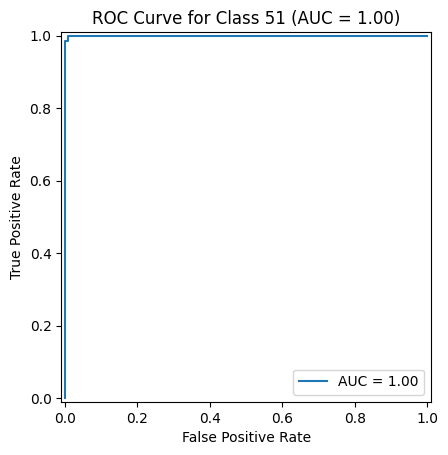

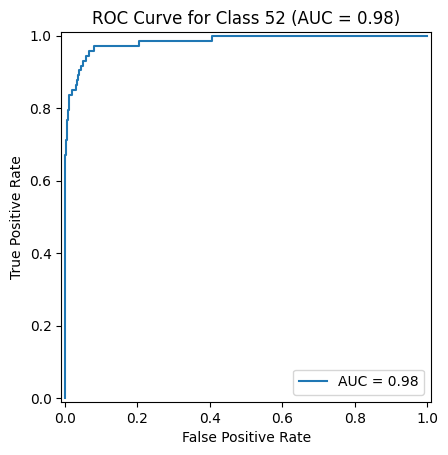

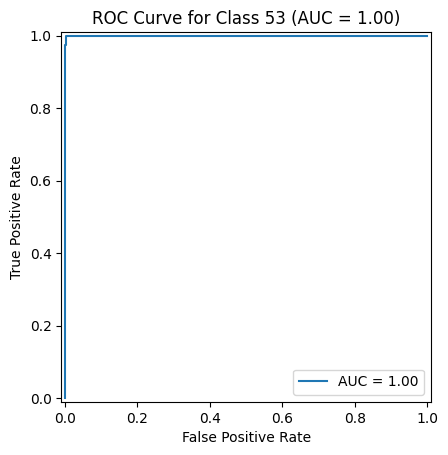

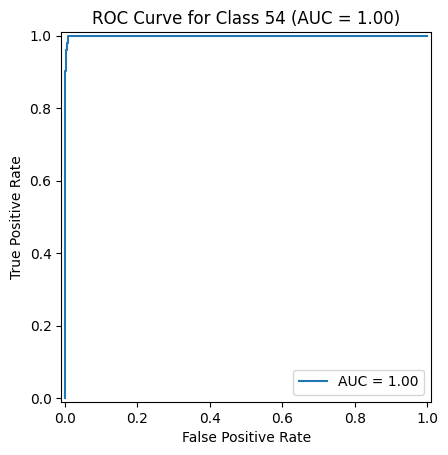

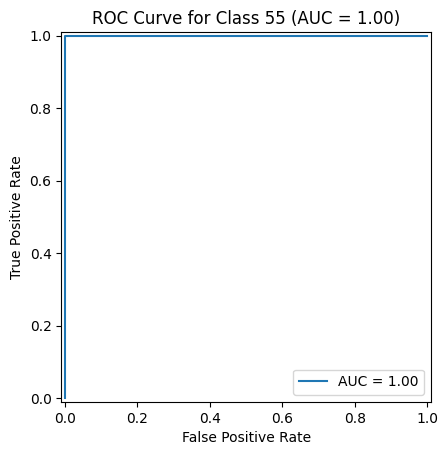

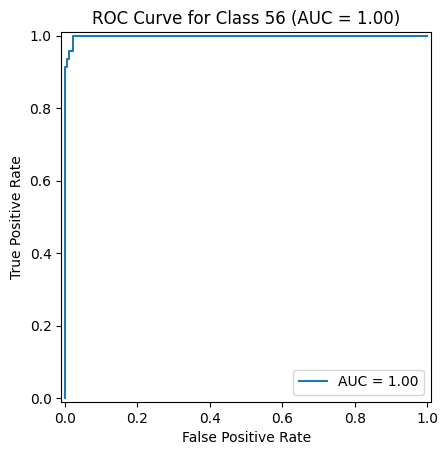

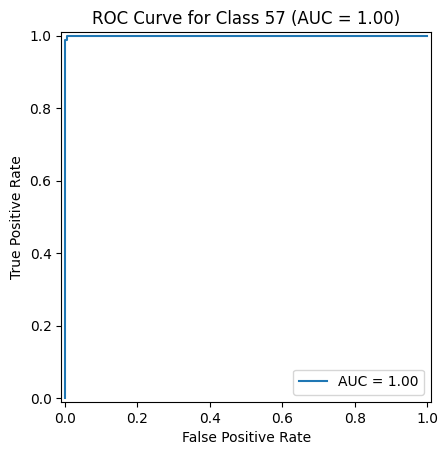

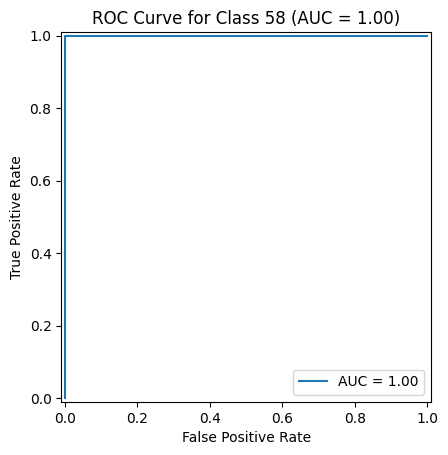

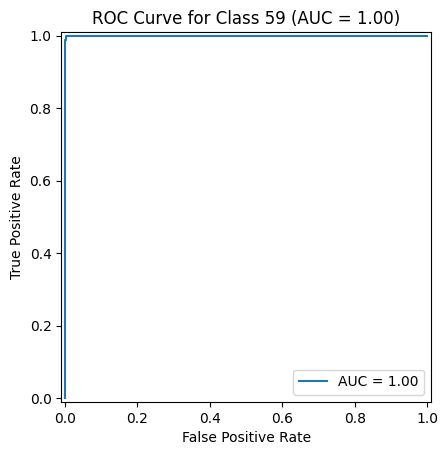

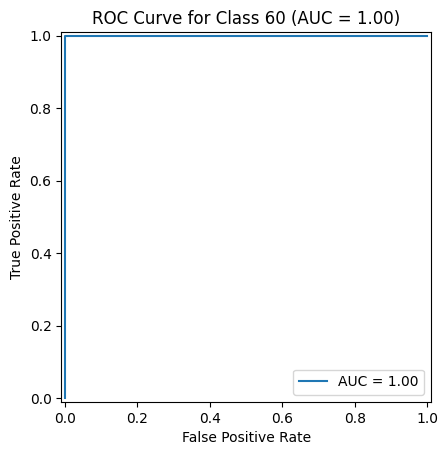

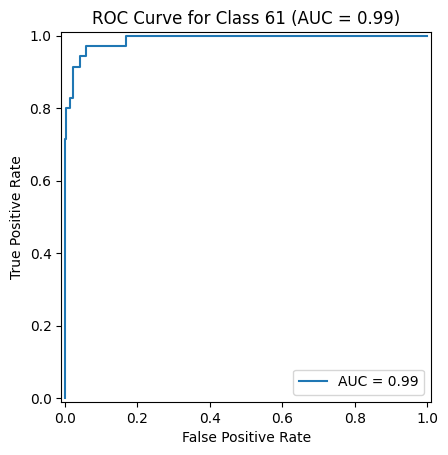

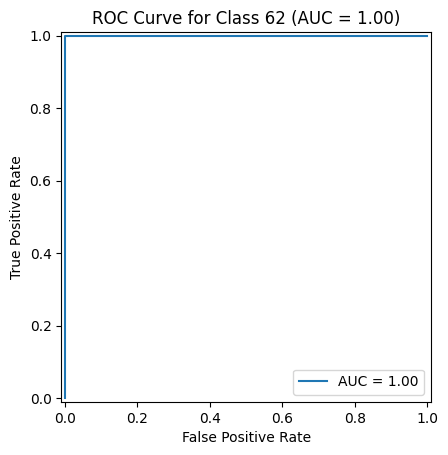

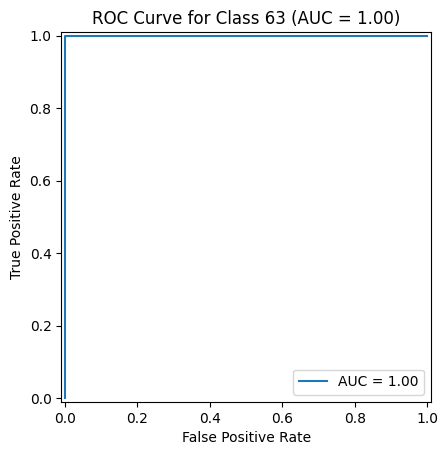

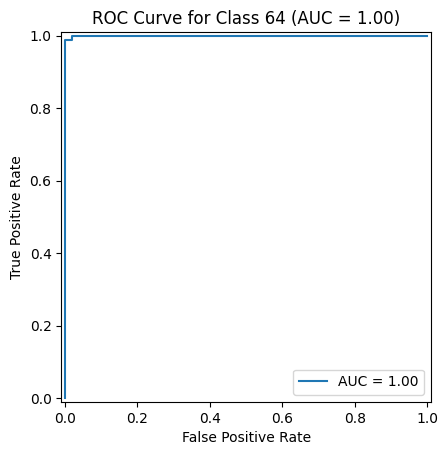

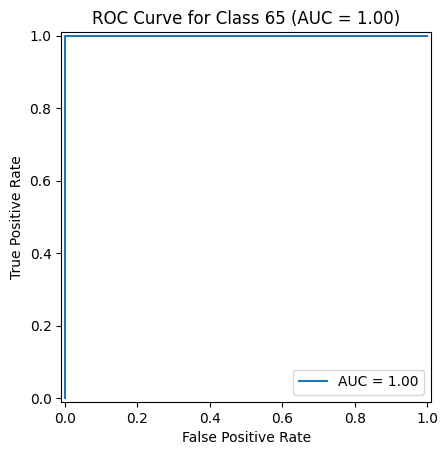

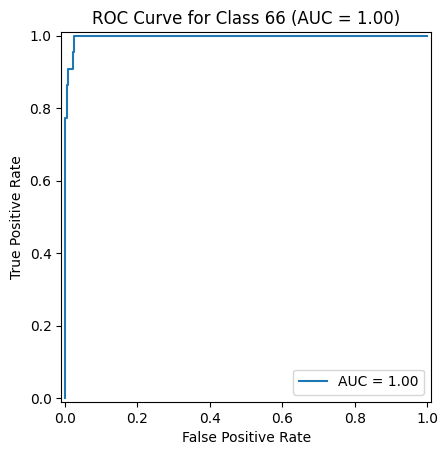

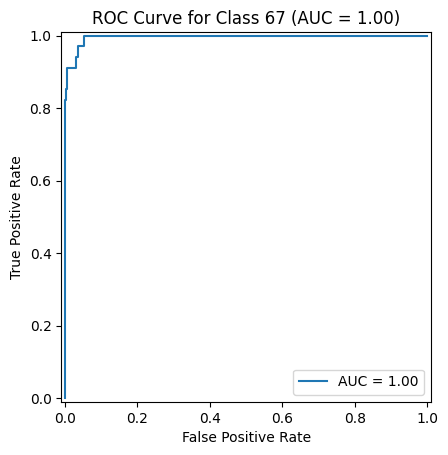

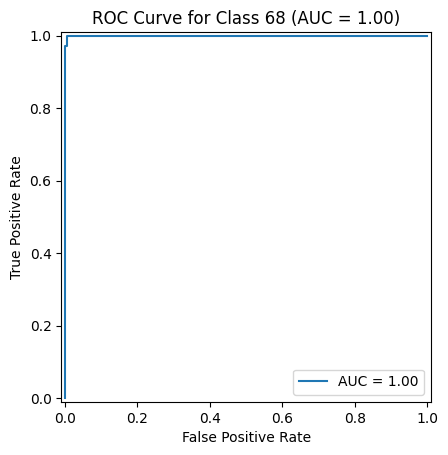

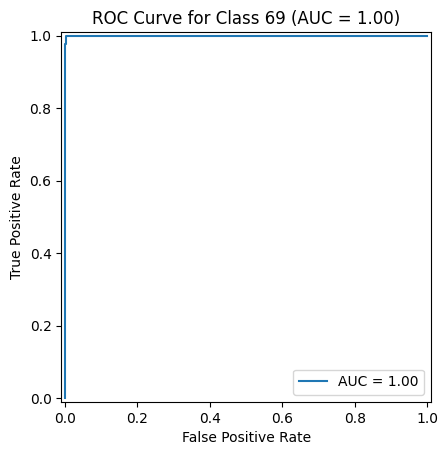

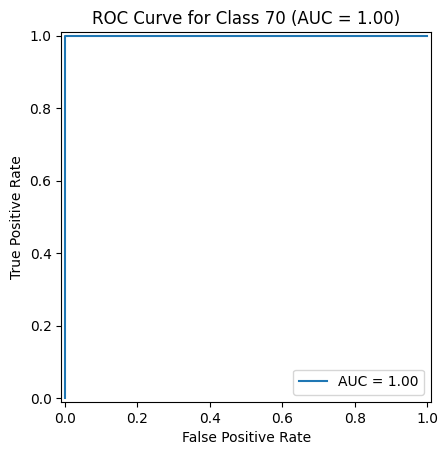

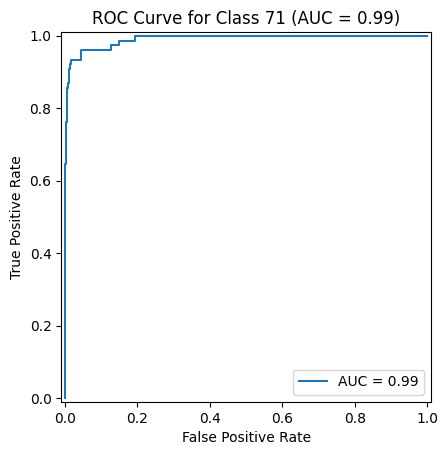

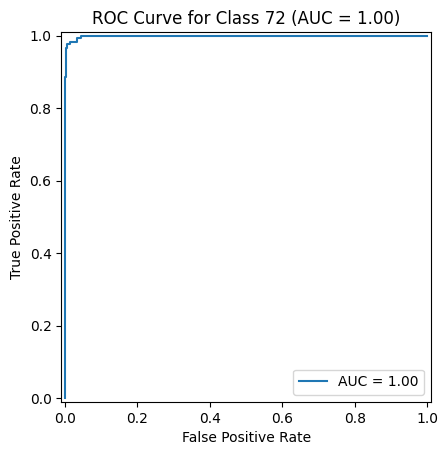

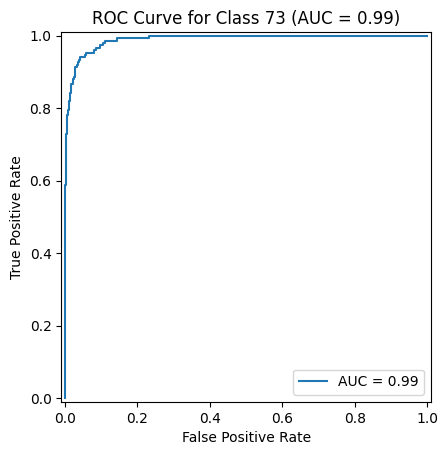

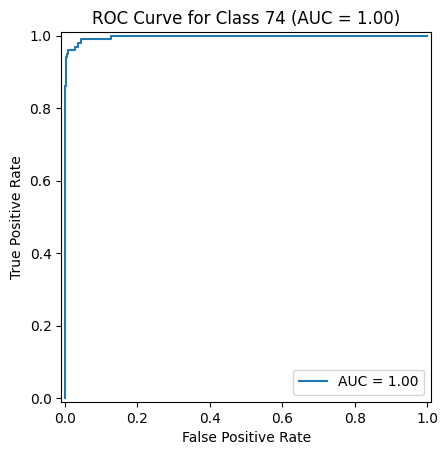

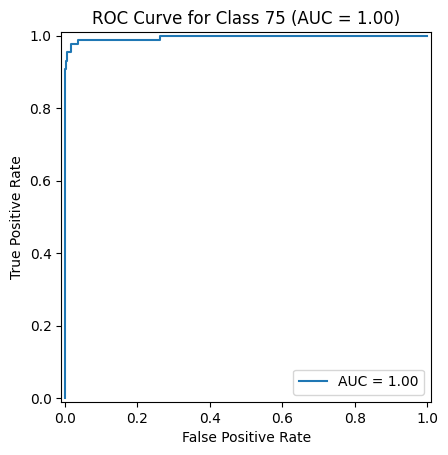

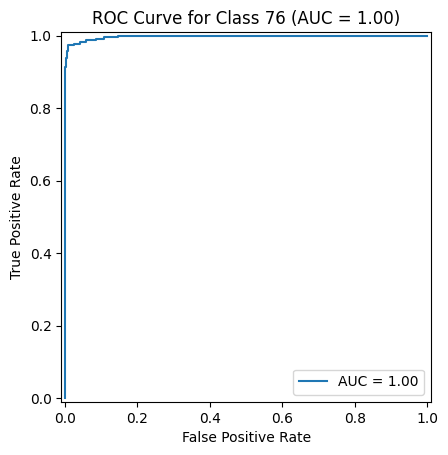

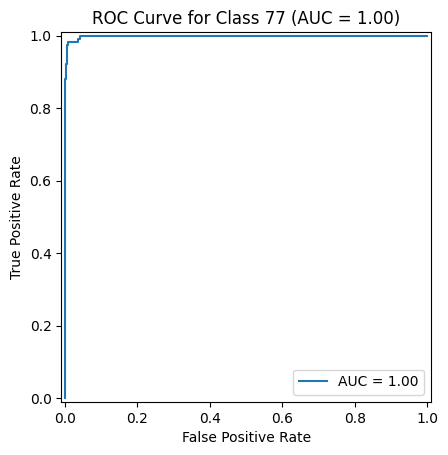

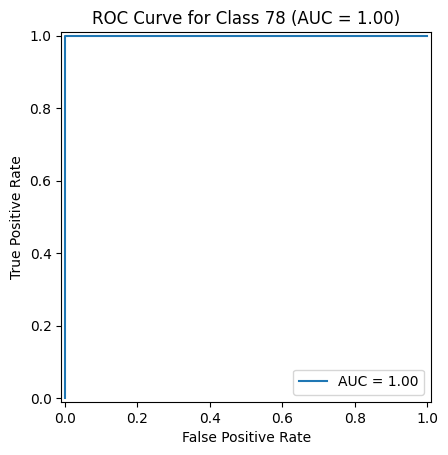

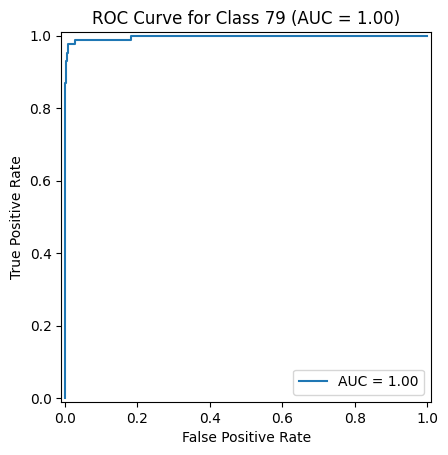

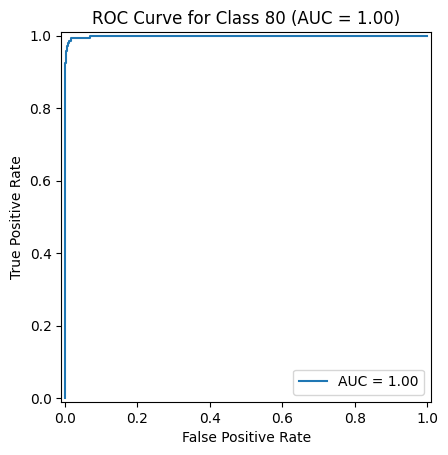

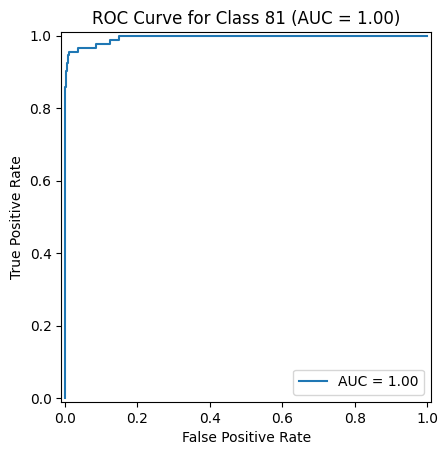

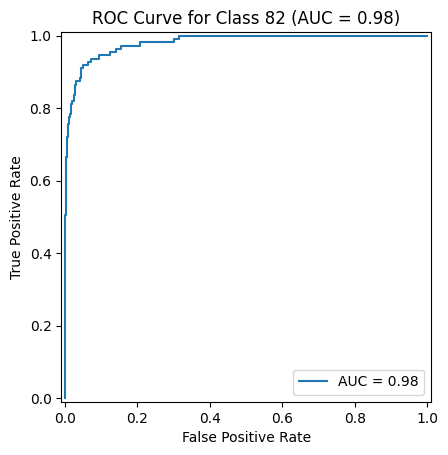

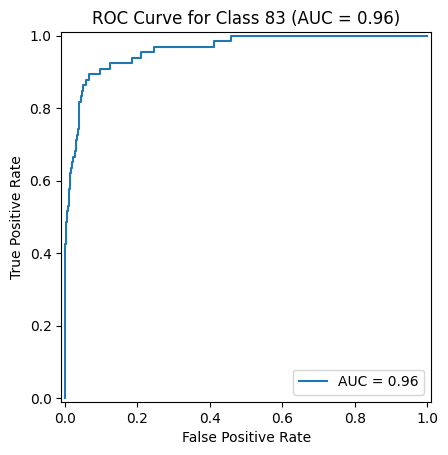

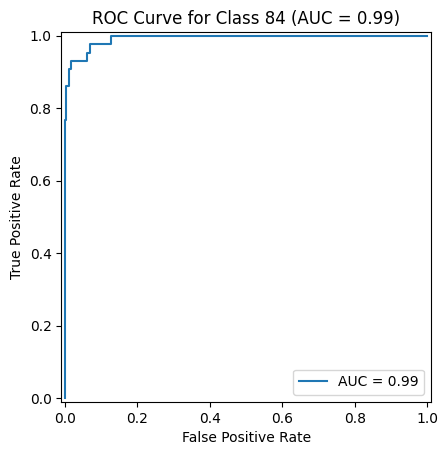

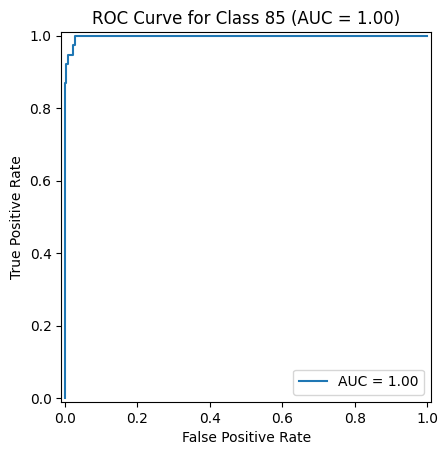

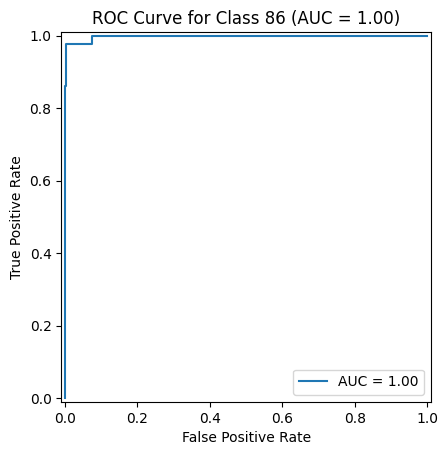

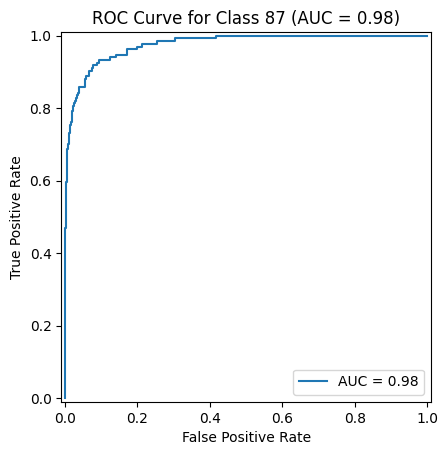

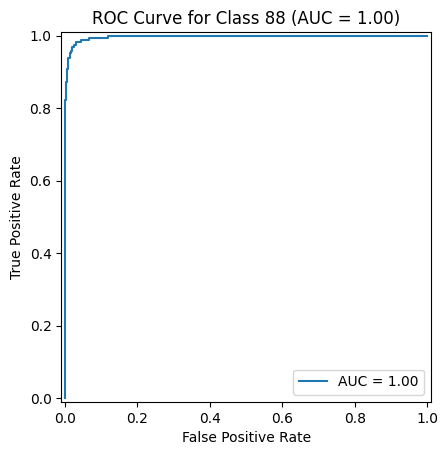

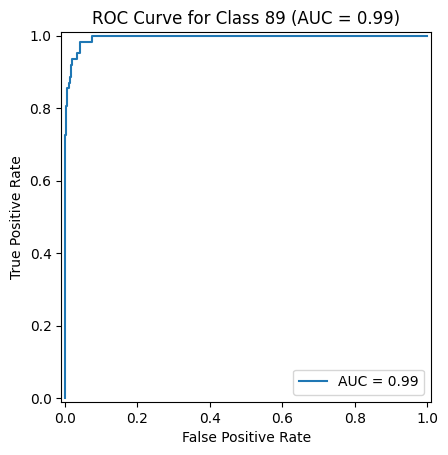

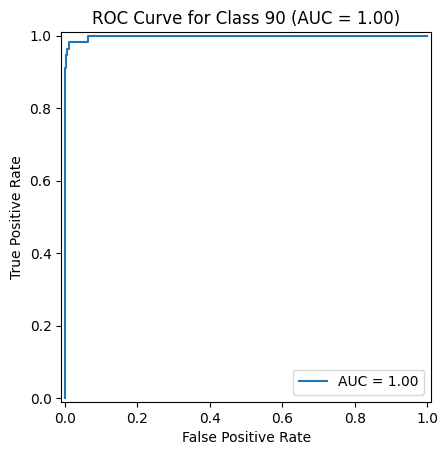

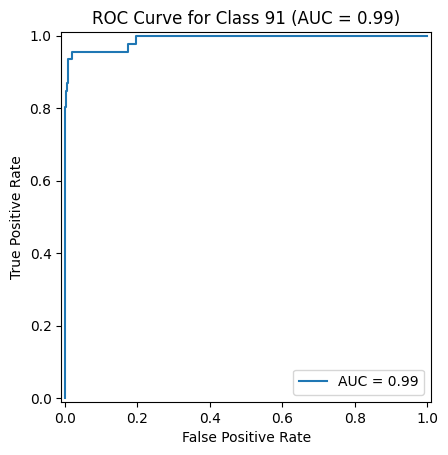

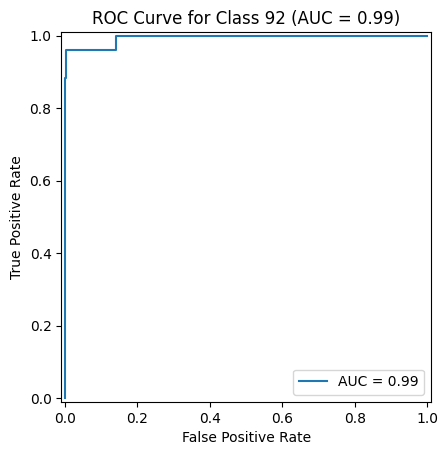

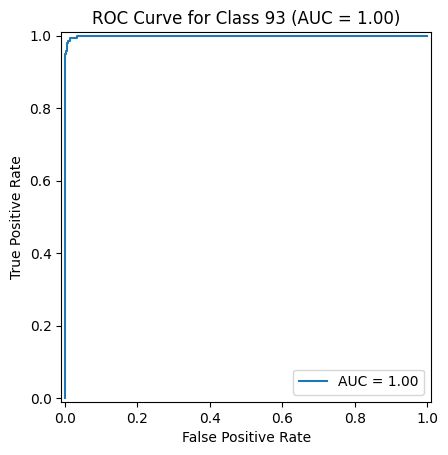

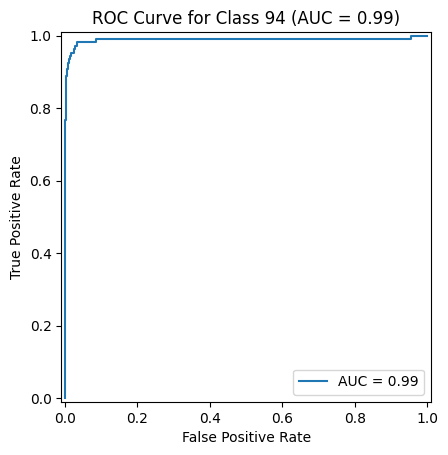

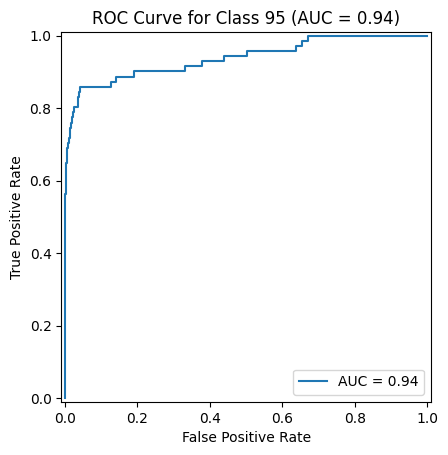

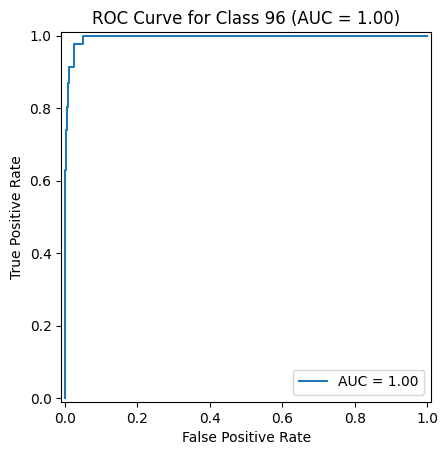

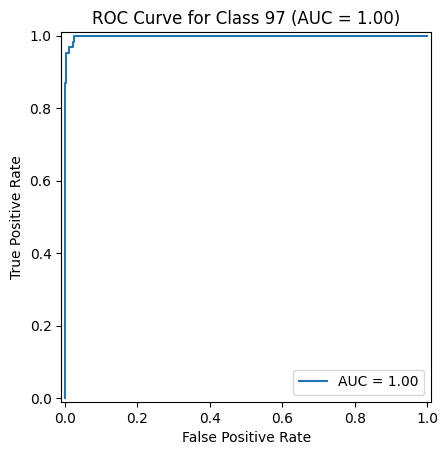

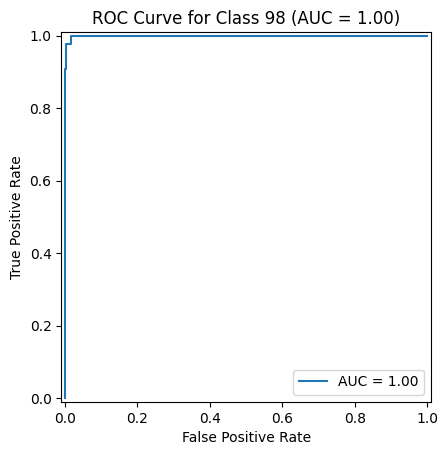

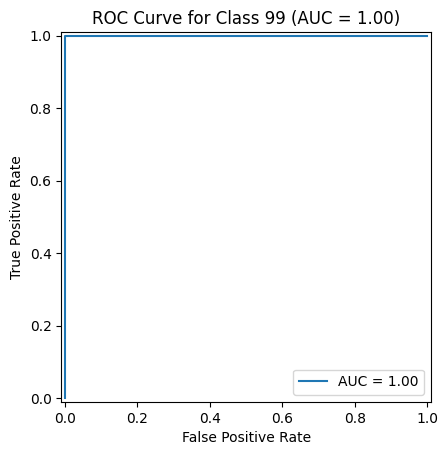

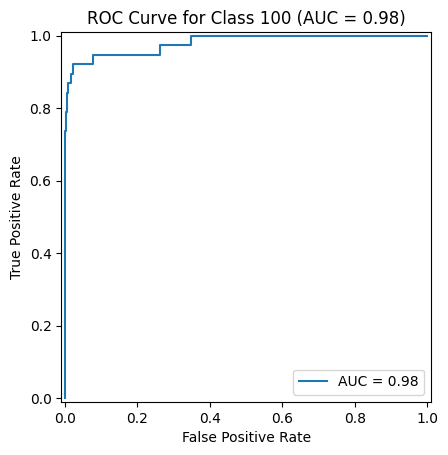

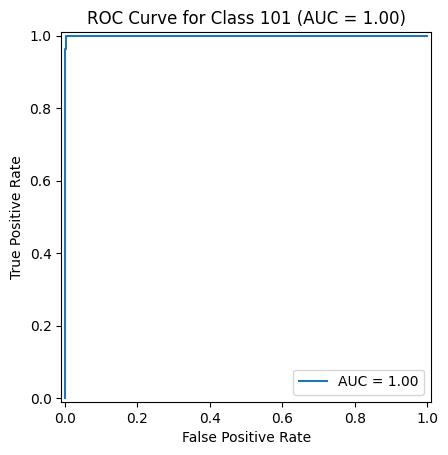

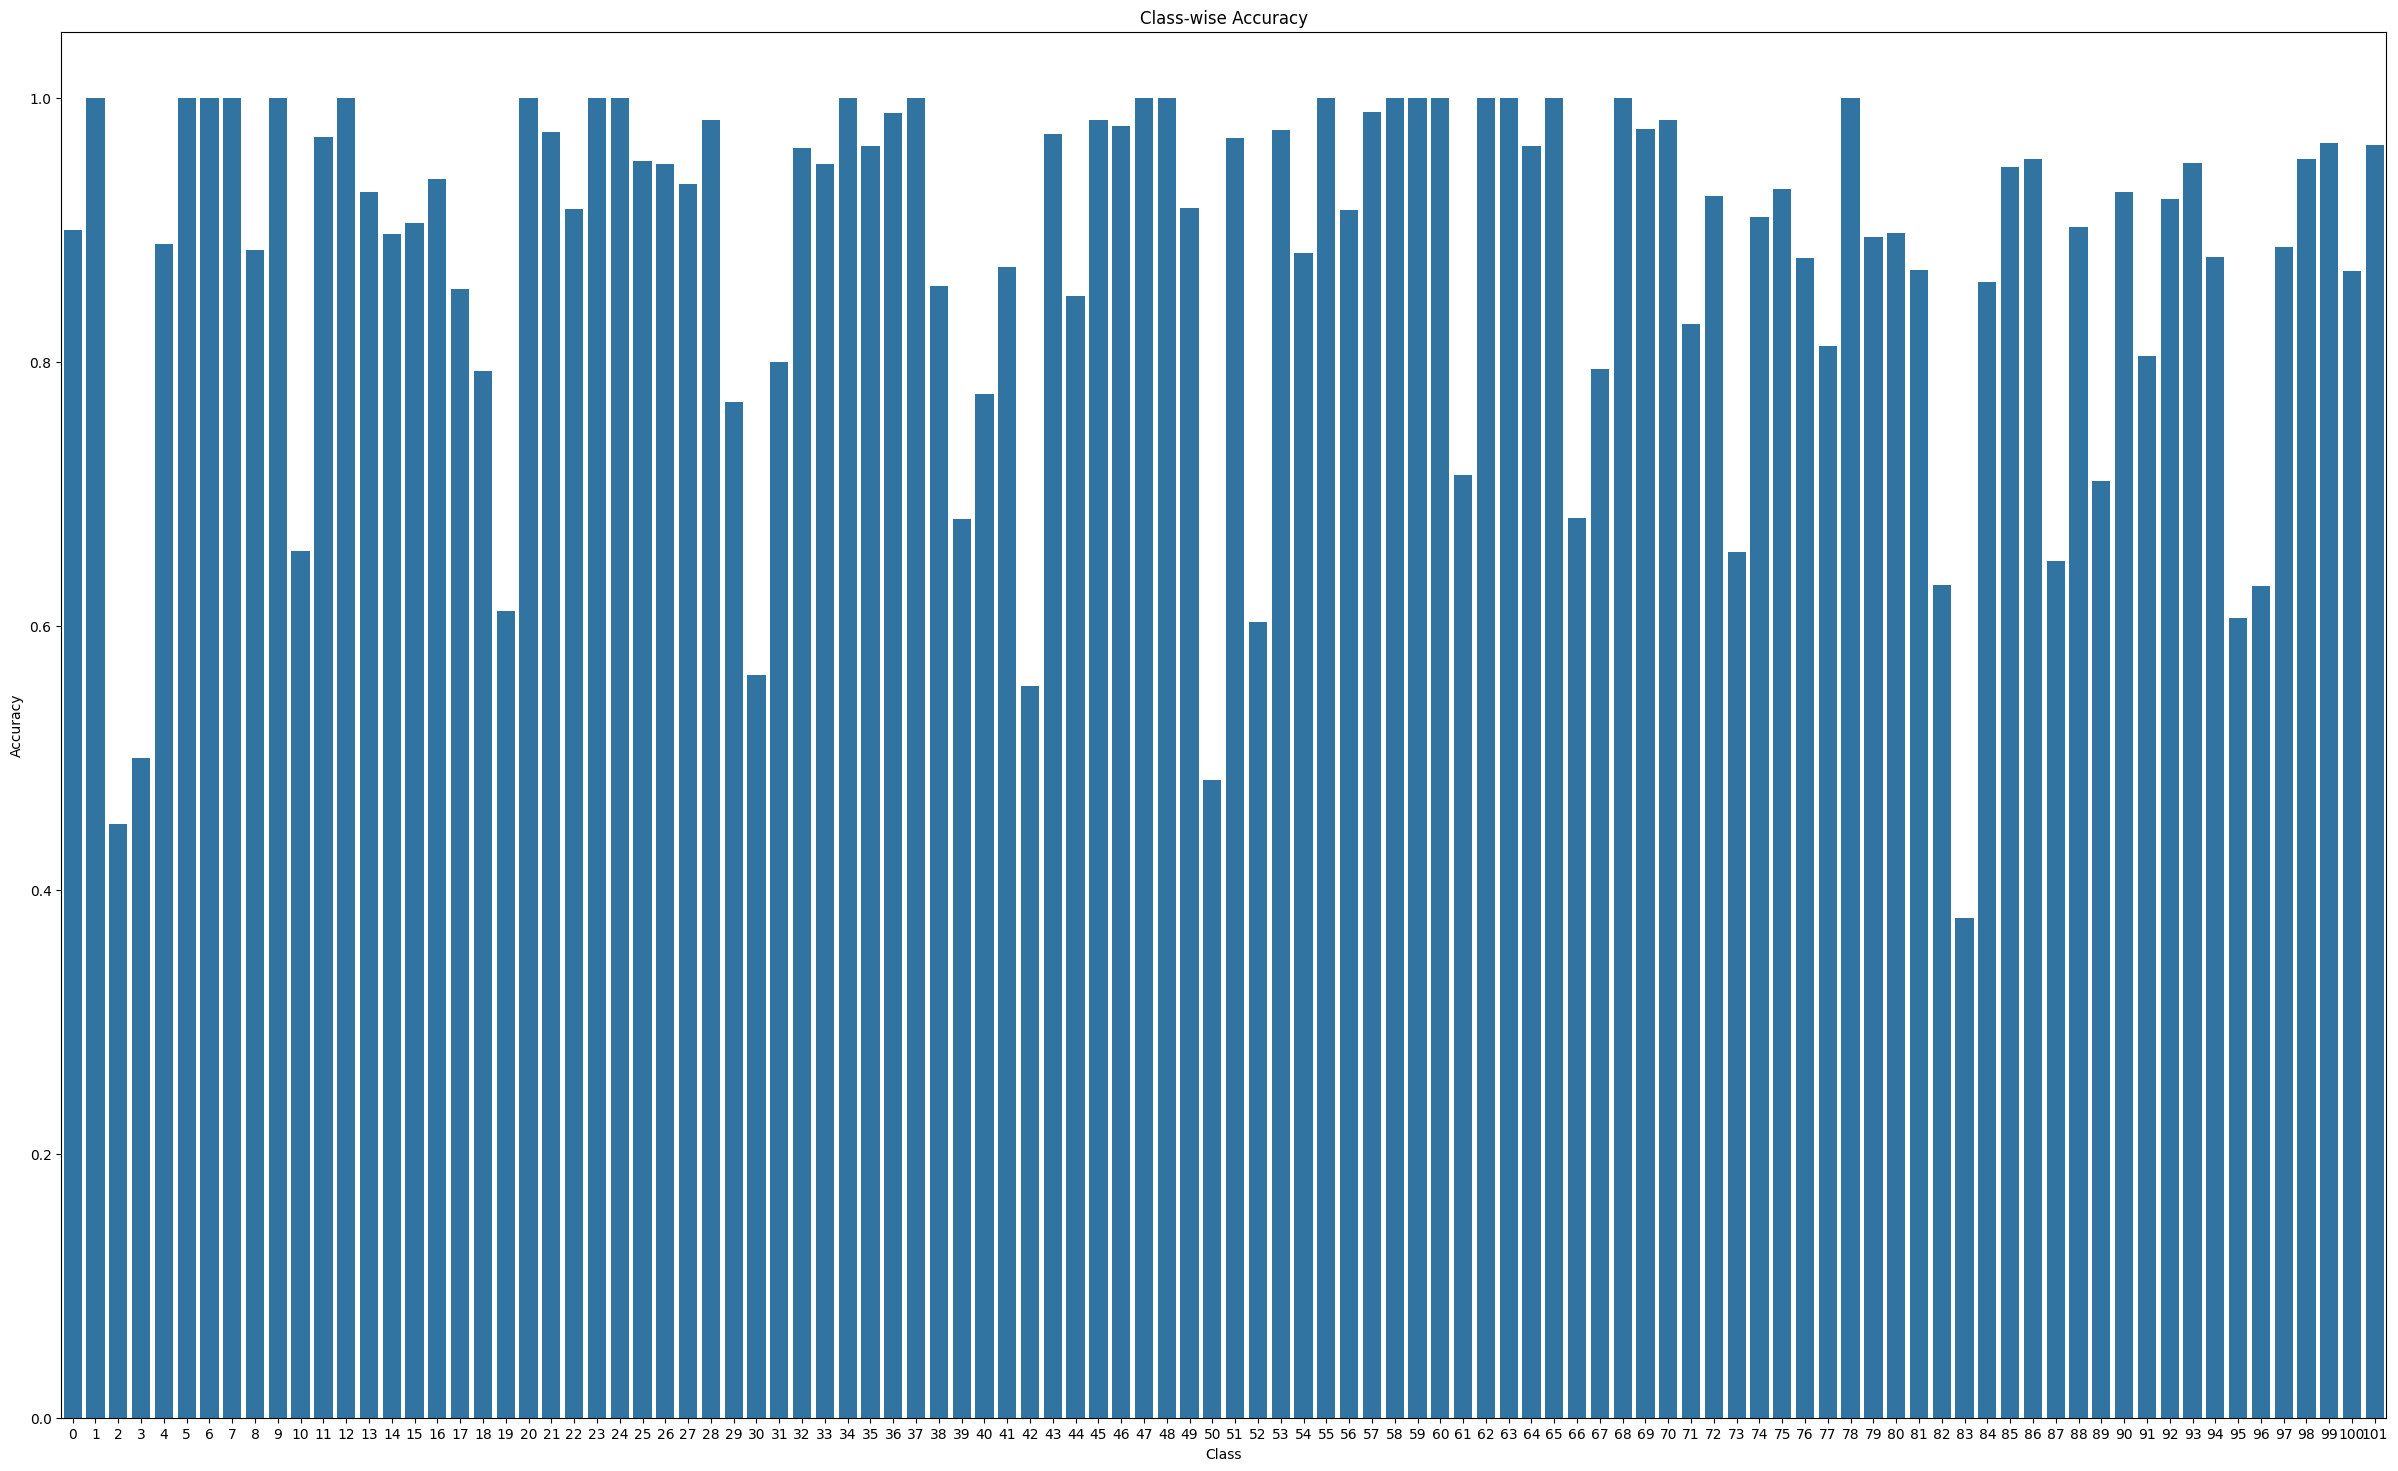

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Set up parameters
num_classes = 102
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels, all_probs = [], [], []

# Get predictions and true labels for the test set
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Binarize the labels for multi-class precision-recall and ROC
all_labels_bin = label_binarize(all_labels, classes=range(num_classes))
all_probs = np.array(all_probs)

# ========================= Confusion Matrix =========================
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(50, 50))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# =================== Precision-Recall Curve (One-vs-Rest) ===================
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title(f"Precision-Recall Curve for Class {i}")
    plt.show()

# ================== ROC Curve and AUC for each class ==================
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title(f"ROC Curve for Class {i} (AUC = {roc_auc:.2f})")
    plt.show()

# ==================== Class-wise Accuracy Bar Plot ====================
class_correct = [0] * num_classes
class_total = [0] * num_classes

# Calculate class-wise accuracy
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for label, pred in zip(labels, preds):
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

class_accuracies = [c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]
plt.figure(figsize=(30, 18))
sns.barplot(x=list(range(num_classes)), y=class_accuracies)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy")
plt.show()
